In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from scipy import stats
from collections import OrderedDict

### データの読み込み

In [2]:
train_ts = pd.read_csv("../data/input/training_set.csv")
print(train_ts.shape)
display(train_ts.head())

(1421705, 6)


object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1

In [3]:
train_ts.dtypes

object_id      int64
mjd          float64
passband       int64
flux         float64
flux_err     float64
detected       int64
dtype: object

In [4]:
train_meta = pd.read_csv("../data/input/training_set_metadata.csv")
print(train_meta.shape)
display(train_meta.head())

(7848, 12)


object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

### 欠損の確認

In [5]:
pd.concat([train_ts.isnull().sum(), train_ts.isnull().sum()/len(train_ts)], axis=1)

0    1
object_id  0  0.0
mjd        0  0.0
passband   0  0.0
flux       0  0.0
flux_err   0  0.0
detected   0  0.0

### サンプルを視覚化    

In [5]:
passband_dict = {0:"u", 1:"g", 2:"r", 3:"i", 4:"z", 5:"y"}

In [6]:
class LightCurve(object):
    '''Light curve object for PLAsTiCC formatted data'''
    
    _passbands = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    
    _pbnames = ['u','g','r','i','z','y']
    
    def __init__(self, data):
        '''Read in light curve data'''

        self.DFlc = data
        self._finalize()
     
    # this is some simple code to demonstrate how to calculate features on these multiband light curves
    # we're not suggesting using these features specifically
    # there also might be additional pre-processing you do before computing anything
    # it's purely for illustration
    def _finalize(self):
        '''Store individual passband fluxes as object attributes'''
        # in this example, we'll use the weighted mean to normalize the features
        weighted_mean = lambda flux, dflux: np.sum(flux*(flux/dflux)**2)/np.sum((flux/dflux)**2)
        
        # define some functions to compute simple descriptive statistics
        normalized_flux_std = lambda flux, wMeanFlux: np.std(flux/wMeanFlux, ddof = 1)
        normalized_amplitude = lambda flux, wMeanFlux: (np.max(flux) - np.min(flux))/wMeanFlux
        normalized_MAD = lambda flux, wMeanFlux: np.median(np.abs((flux - np.median(flux))/wMeanFlux))
        beyond_1std = lambda flux, wMeanFlux: sum(np.abs(flux - wMeanFlux) > np.std(flux, ddof = 1))/len(flux)
        
        for pb in self._passbands:
            ind = self.DFlc['passband'] == pb
            pbname = self._pbnames[pb]
            
            if len(self.DFlc[ind]) == 0:
                setattr(self, f'{pbname}Std', np.nan)
                setattr(self, f'{pbname}Amp', np.nan)
                setattr(self, f'{pbname}MAD', np.nan)
                setattr(self, f'{pbname}Beyond', np.nan)
                setattr(self, f'{pbname}Skew', np.nan)
                continue
            
            f  = self.DFlc['flux'][ind]
            df = self.DFlc['flux_err'][ind]
            m  = weighted_mean(f, df)
            
            # we'll save the measurements in each passband to simplify access.
            setattr(self, f'{pbname}Flux', f)
            setattr(self, f'{pbname}FluxUnc', df)
            setattr(self, f'{pbname}Mean', m)
            
            # compute the features
            std = normalized_flux_std(f, df)
            amp = normalized_amplitude(f, m)
            mad = normalized_MAD(f, m)
            beyond = beyond_1std(f, m)
            skew = stats.skew(f) 
            
            # and save the features
            setattr(self, f'{pbname}Std', std)
            setattr(self, f'{pbname}Amp', amp)
            setattr(self, f'{pbname}MAD', mad)
            setattr(self, f'{pbname}Beyond', beyond)
            setattr(self, f'{pbname}Skew', skew)
        
        # we can also construct features between passbands
        pbs = list(self._passbands.keys())
        for i, lpb in enumerate(pbs[0:-1]):
            rpb = pbs[i+1]
            
            lpbname = self._pbnames[lpb]
            rpbname = self._pbnames[rpb]
            
            colname = '{}Minus{}'.format(lpbname, rpbname.upper())
            lMean = getattr(self, f'{lpbname}Mean', np.nan)
            rMean = getattr(self, f'{rpbname}Mean', np.nan)
            col = -2.5*np.log10(lMean/rMean) if lMean> 0 and rMean > 0 else -999
            setattr(self, colname, col)
    
    # this is a simple routine to visualize a light curve
    # it can plot vs the MJD array of the light curve
    # or vs an optional `phase` array that you pass 
    def plot_multicolor_lc(self, phase=None, ax=None):
        '''Plot the multiband light curve'''

        if ax is None:
            fig, ax = plt.subplots(figsize=(8,6))
        
        if phase is None:
            phase = []
        if len(phase) != len(self.DFlc):
            phase = self.DFlc['mjd']
            xlabel = 'MJD'
        else:
            xlabel = 'Phase'
            
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            ind = self.DFlc['passband'] == pb
            if len(self.DFlc[ind]) == 0:
                continue
            ax.errorbar(phase[ind], 
                     self.DFlc['flux'][ind],
                     self.DFlc['flux_err'][ind],
                     fmt = 'o', color = self._passbands[pb], label = f'{pbname}')
        ax.legend(ncol=4, frameon=True, loc='upper right')
        ax.set_xlabel(f'{xlabel}', fontsize='large')
        ax.set_ylabel('Flux', fontsize='large')
        # fig.suptitle(self.filename, fontsize='x-large')
        # fig.tight_layout(rect=[0, 0, 1, 0.97])
    
    def get_features(self):
        '''Return all the features for this object'''
        variables = ['Std', 'Amp', 'MAD', 'Beyond', 'Skew']
        feats = []
        for i, pb in enumerate(self._passbands):
            pbname = self._pbnames[pb]
            feats += [getattr(self, f'{pbname}{x}', np.nan) for x in variables]
        return feats


6 18556


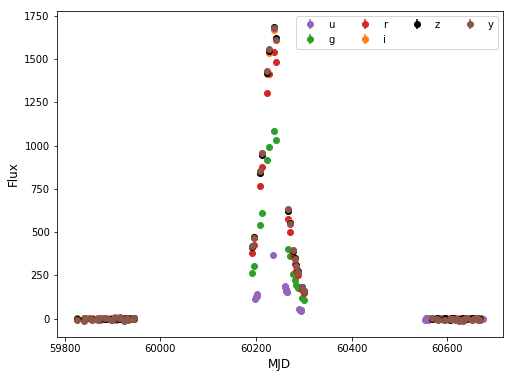

6 77157


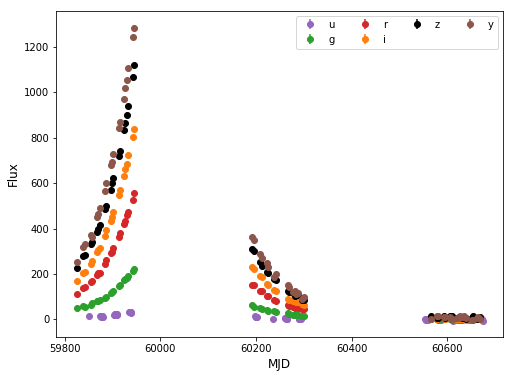

6 83348


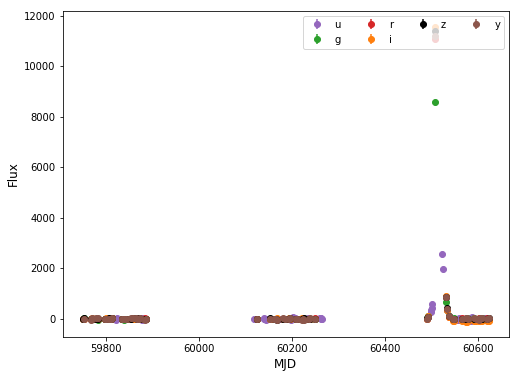

6 198103


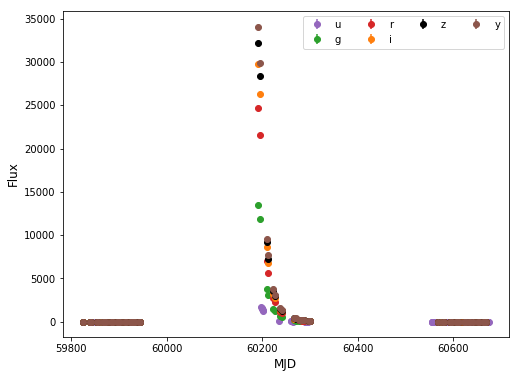

6 201890


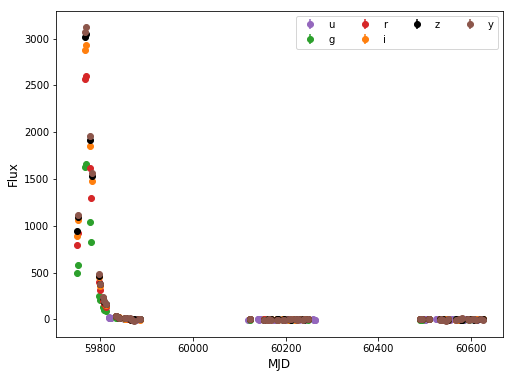

6 282647


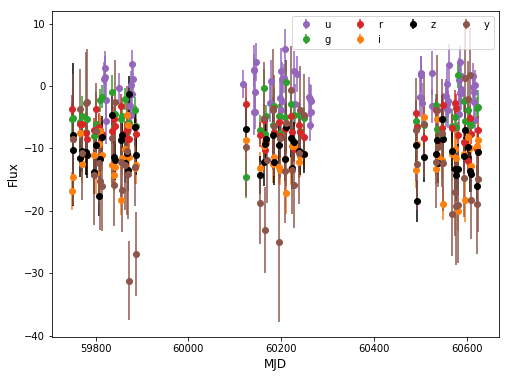

6 332684


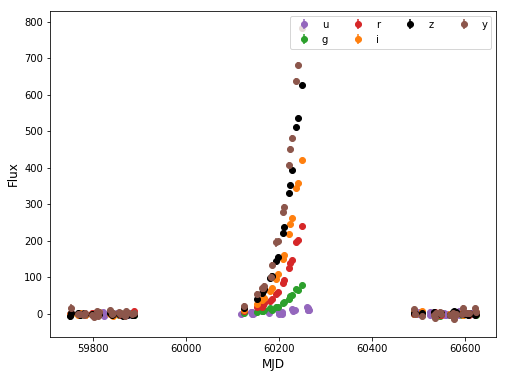

6 1497514


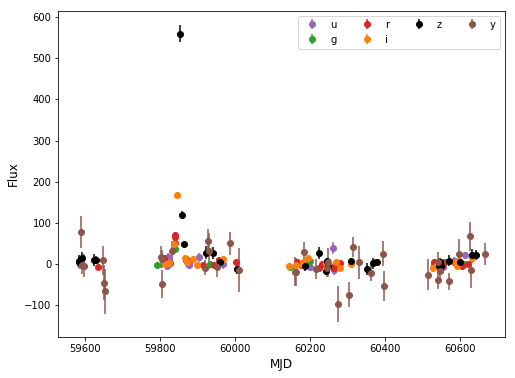

6 1516088


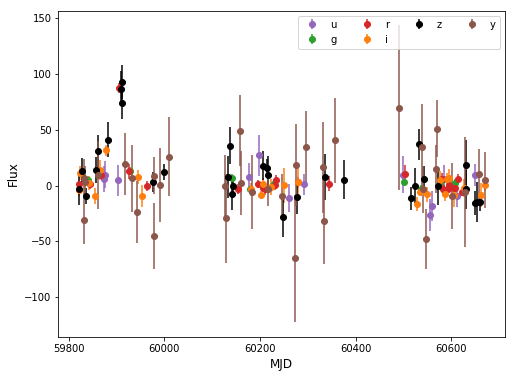

6 1854631


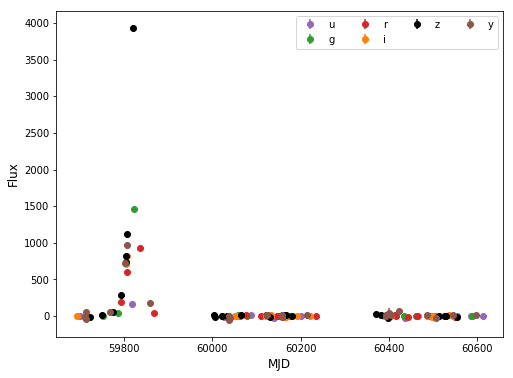

15 4173


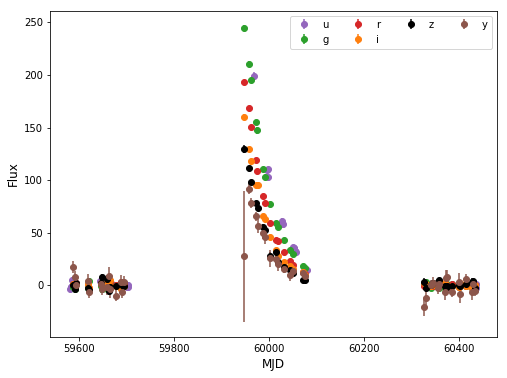

15 23116


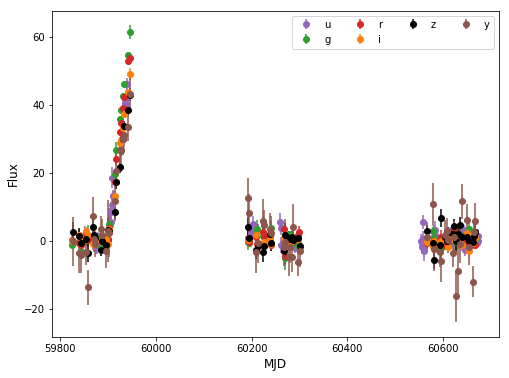

15 97406


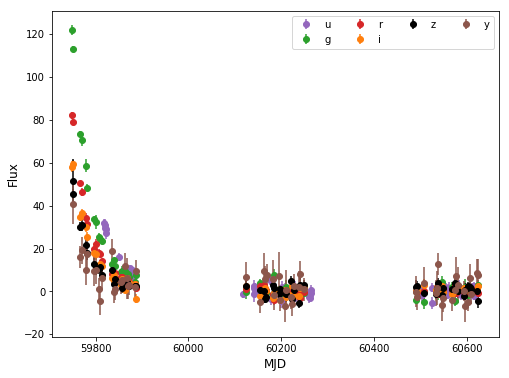

15 113669


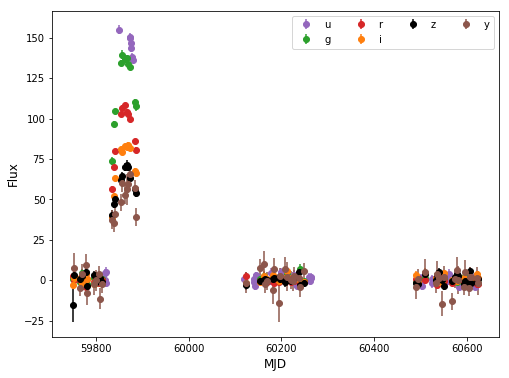

15 133234


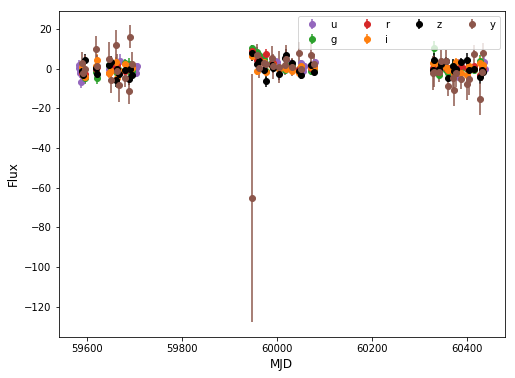

15 148996


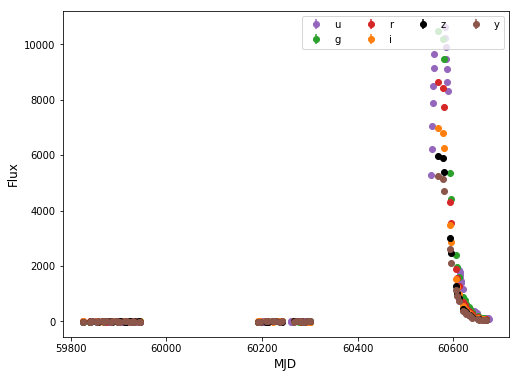

15 254618


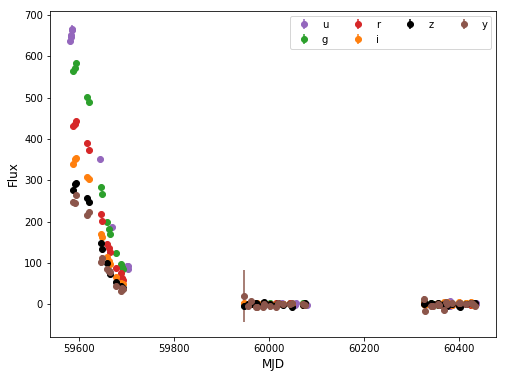

15 279292


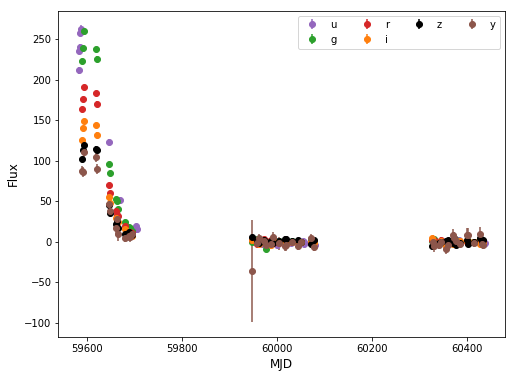

15 1135692


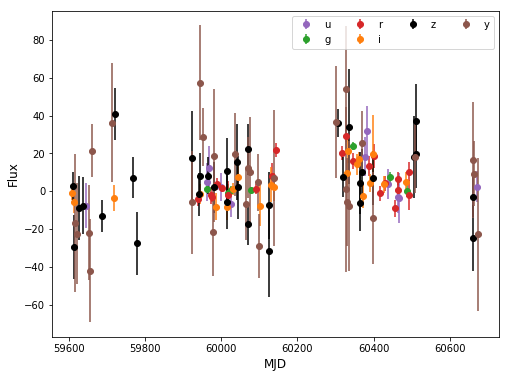

15 1454581


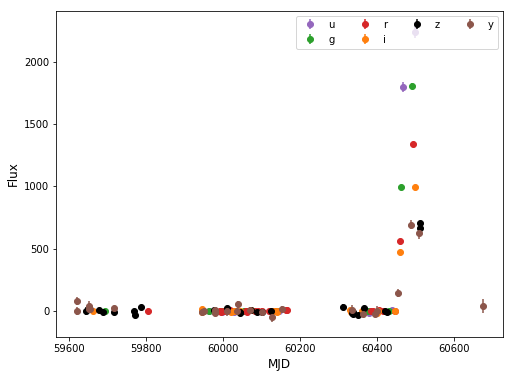

16 2677


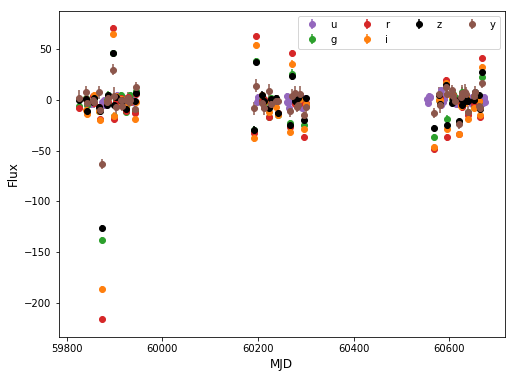

16 4171


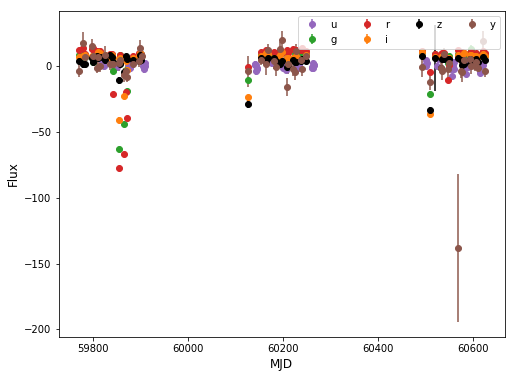

16 7566


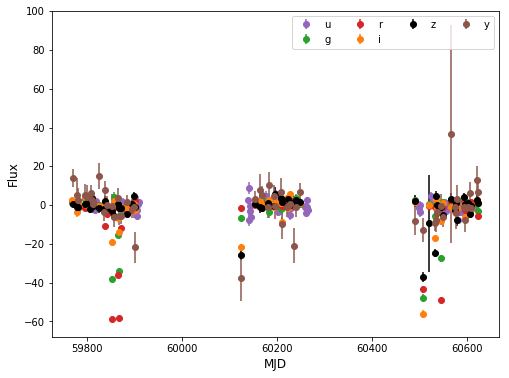

16 7756


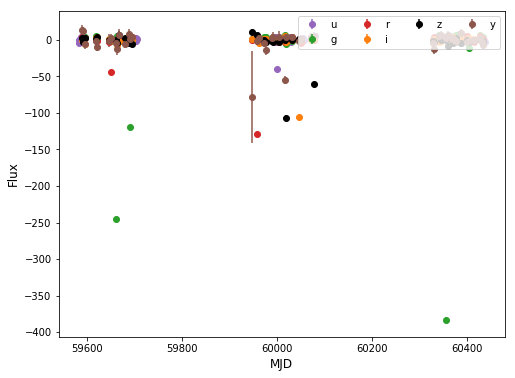

16 8784


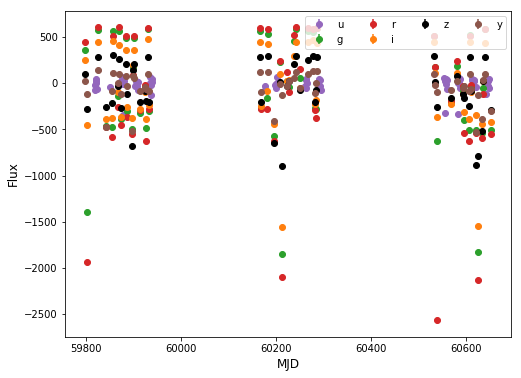

16 11165


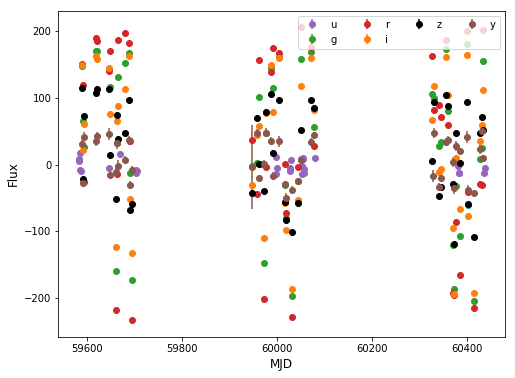

16 15626


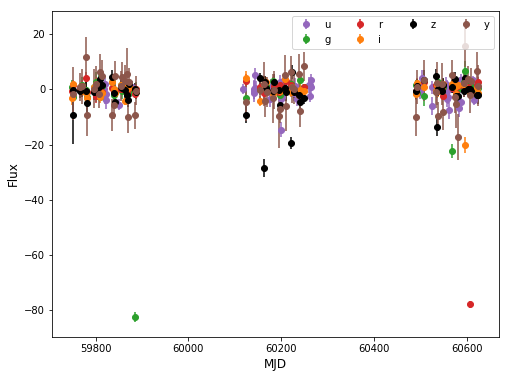

16 15700


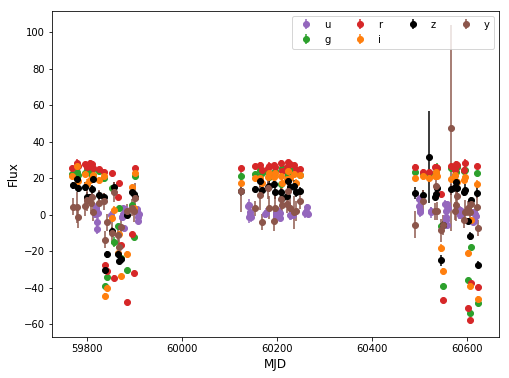

16 16339


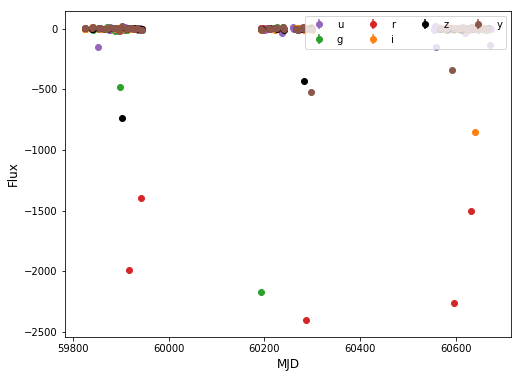

16 16349


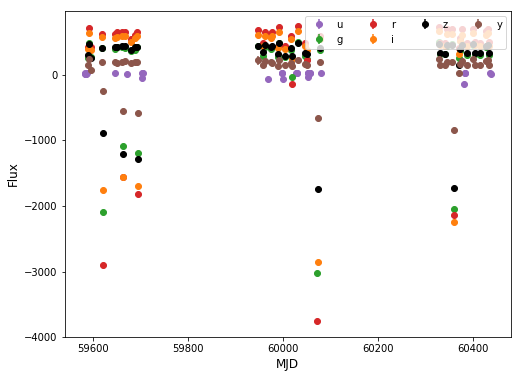

42 730


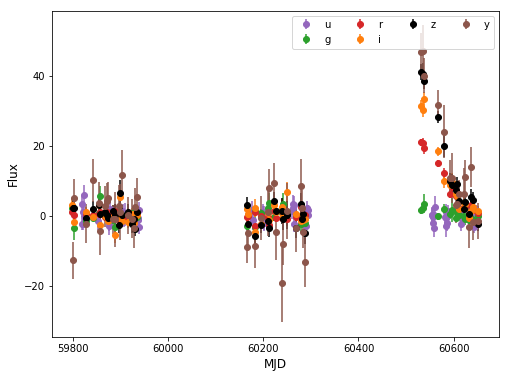

42 1632


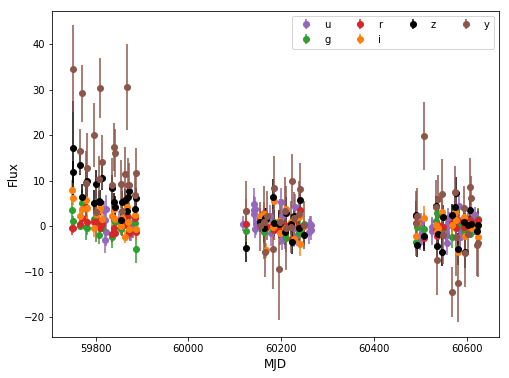

42 2103


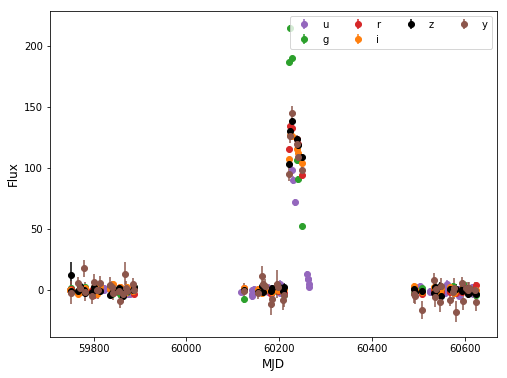

42 2300


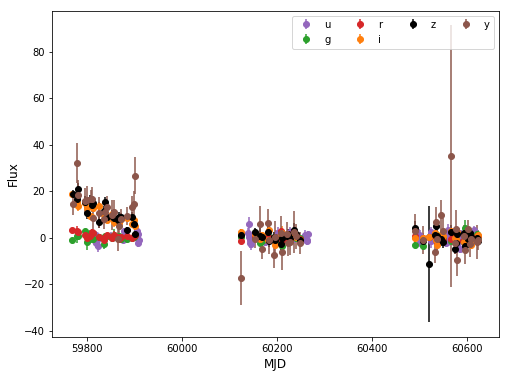

42 3285


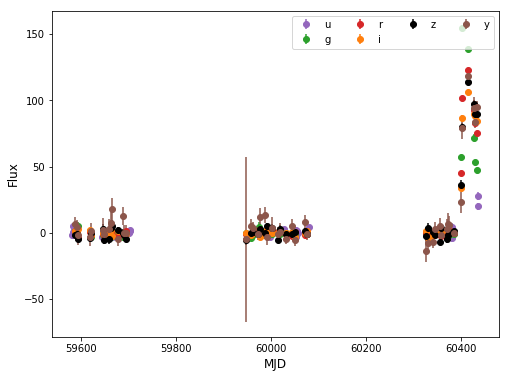

42 4132


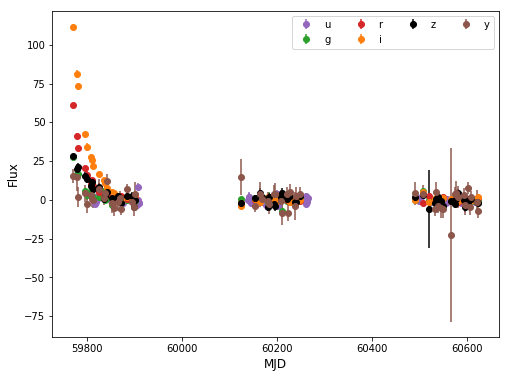

42 4220


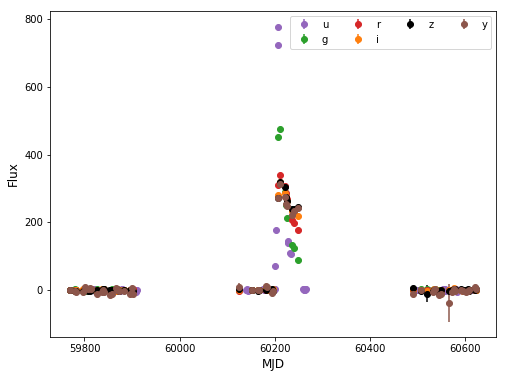

42 5527


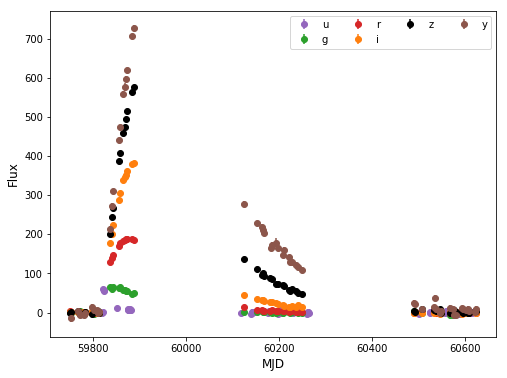

42 7033


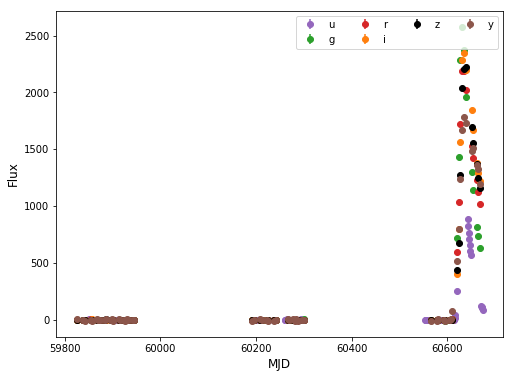

42 9936


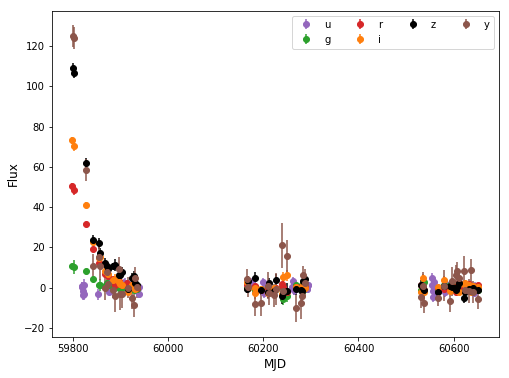

52 10757


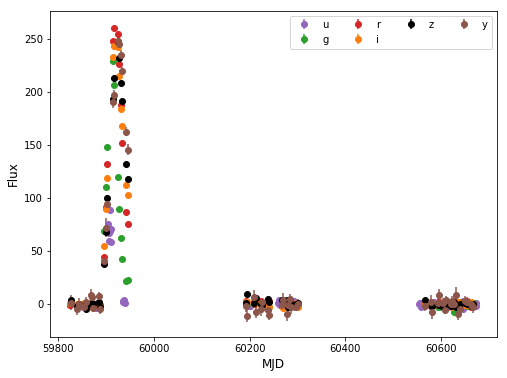

52 11773


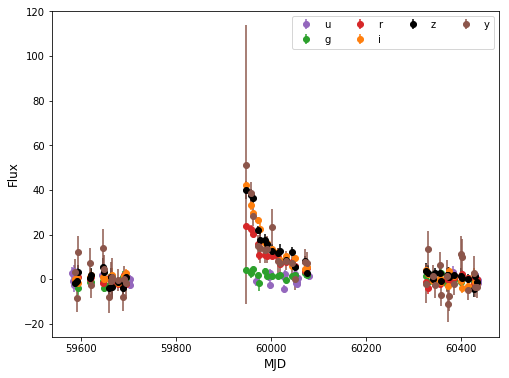

52 13138


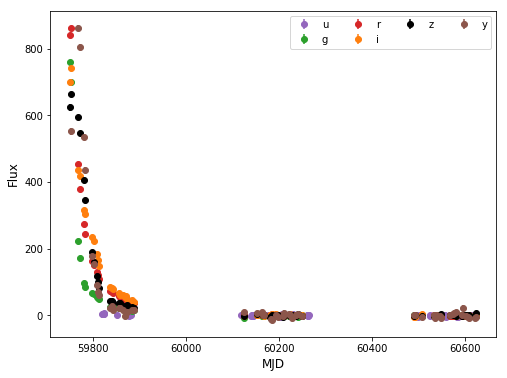

52 14279


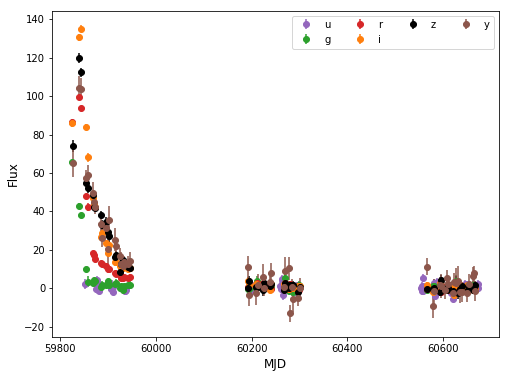

52 15718


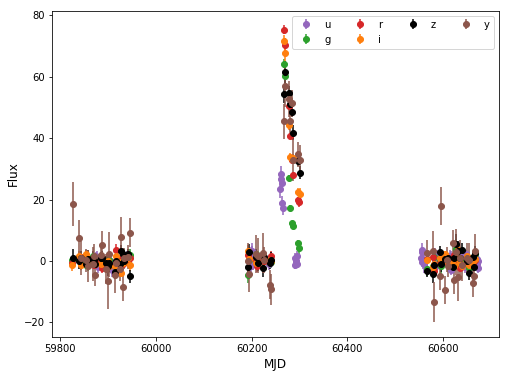

52 16496


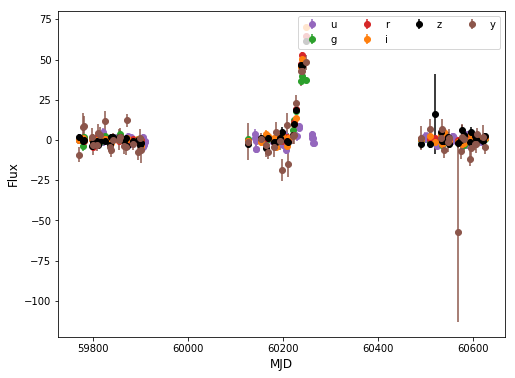

52 23127


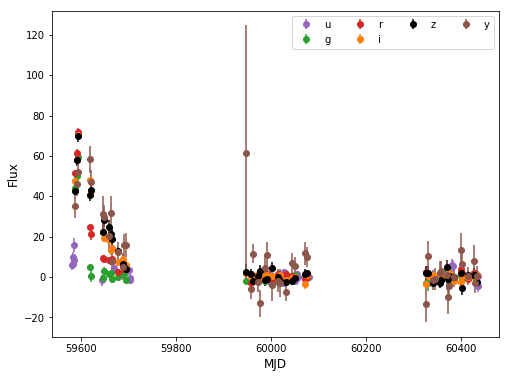

52 23409


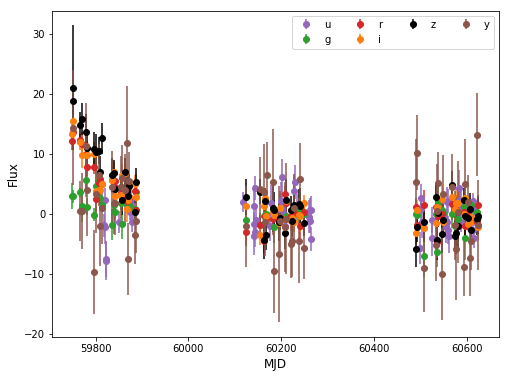

52 23822


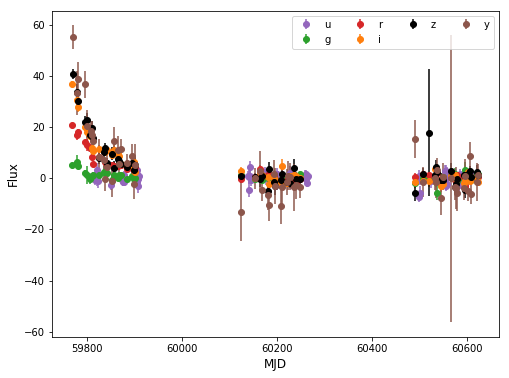

52 34012


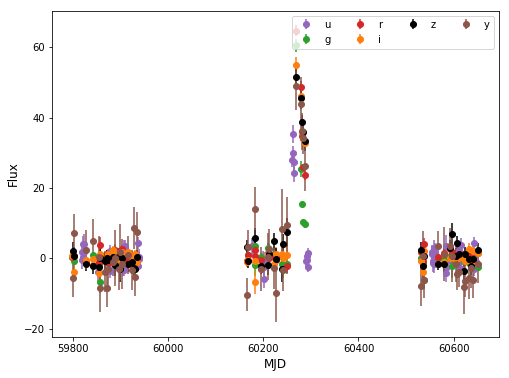

53 133773


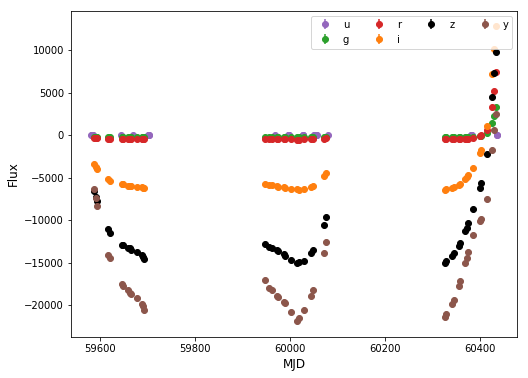

53 268977


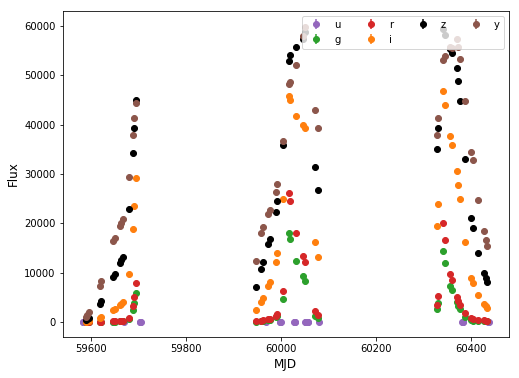

53 278480


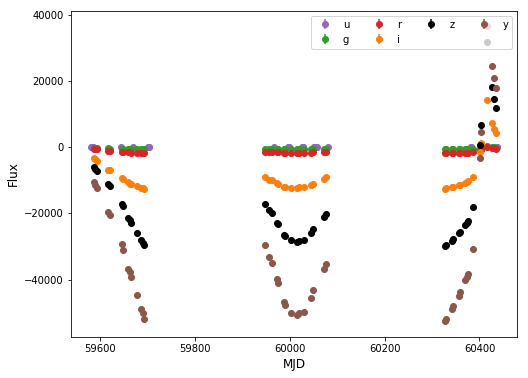

53 288194


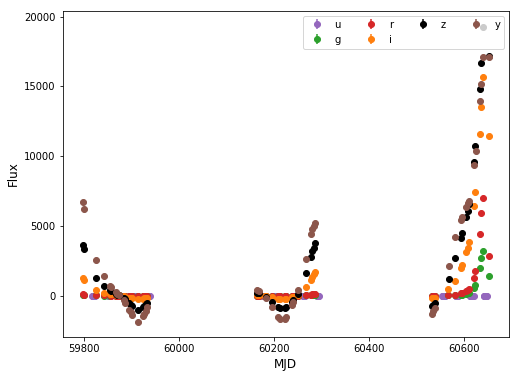

53 2298767


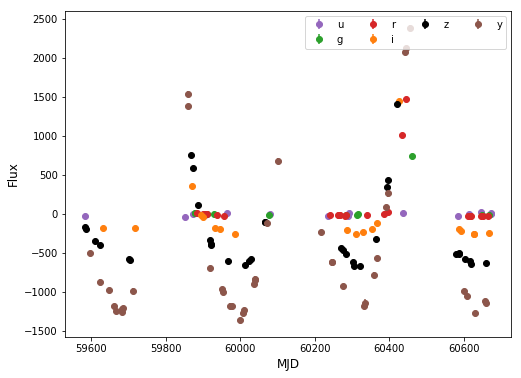

53 4416529


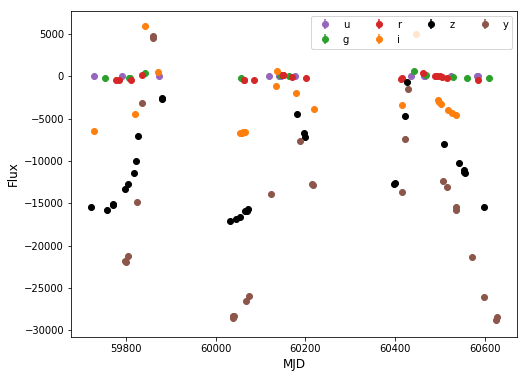

53 4855013


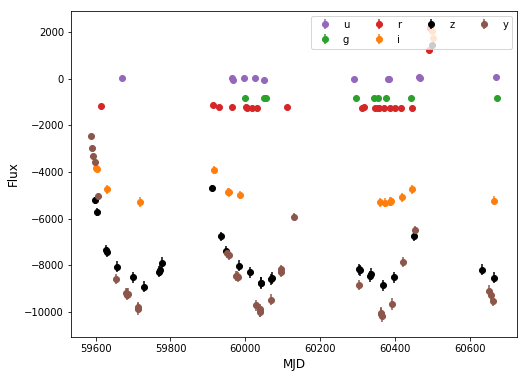

53 16504681


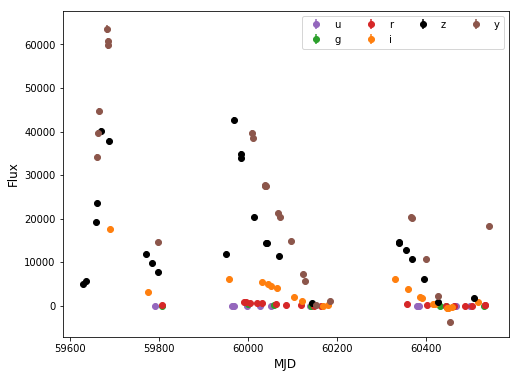

53 17991828


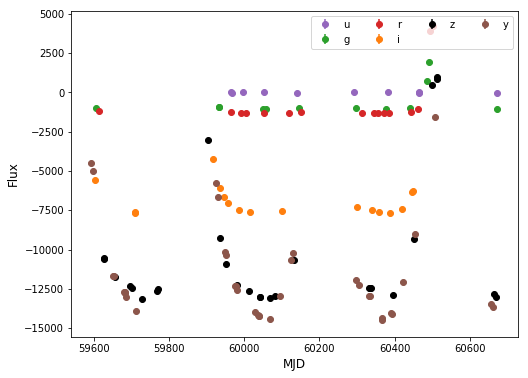

53 20578786


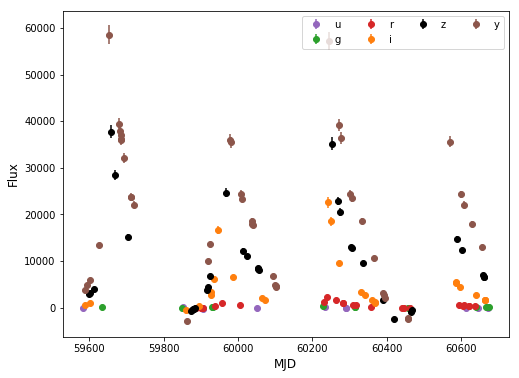

62 3910


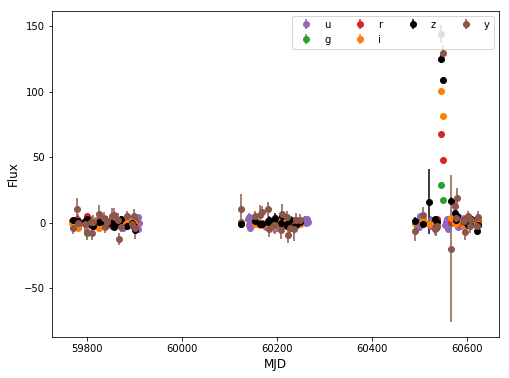

62 7703


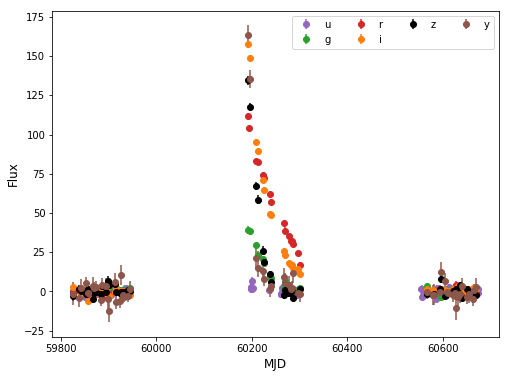

62 11770


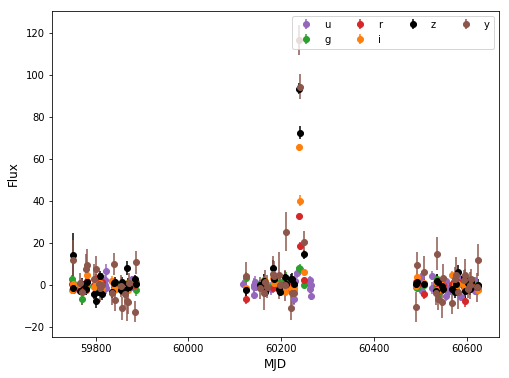

62 17370


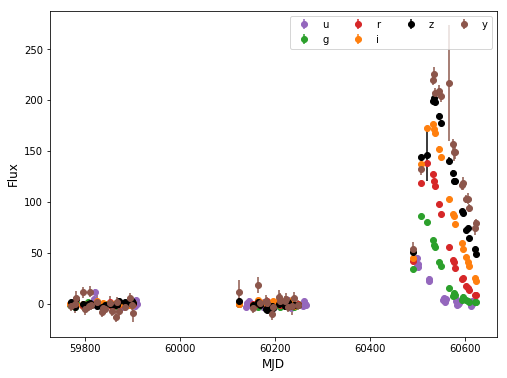

62 18645


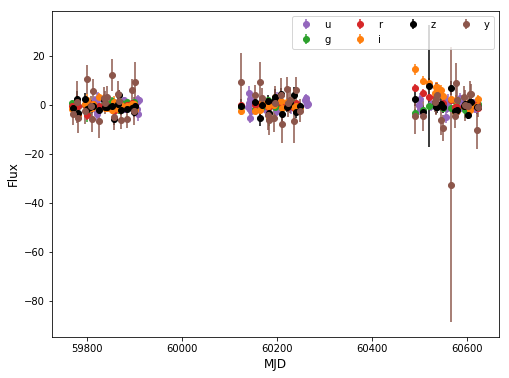

62 18706


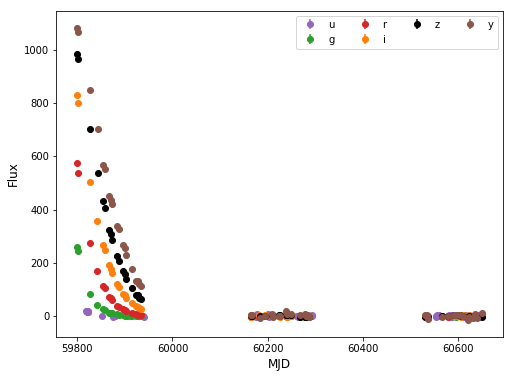

62 19213


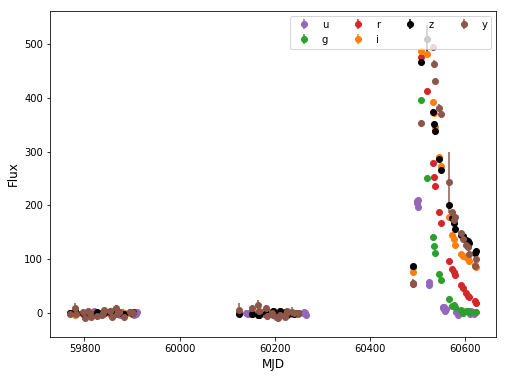

62 20567


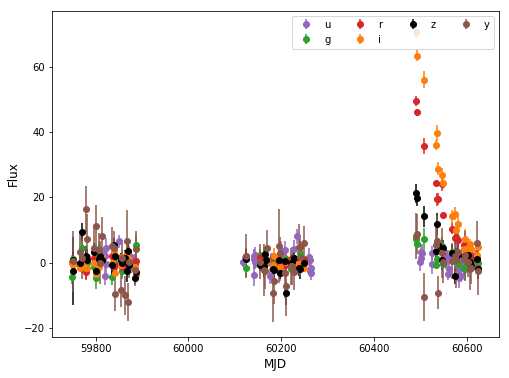

62 26338


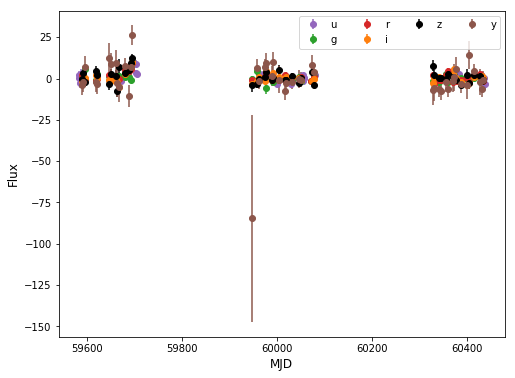

62 29670


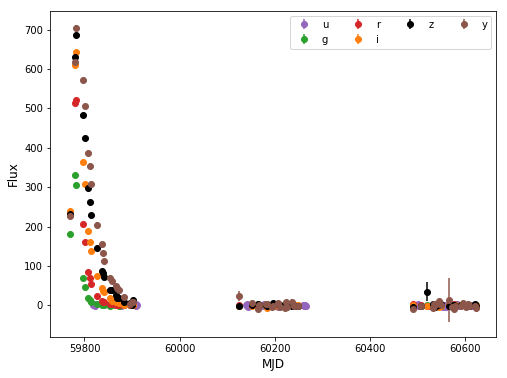

64 62187


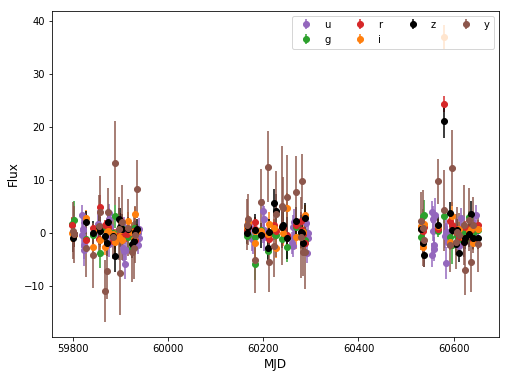

64 139362


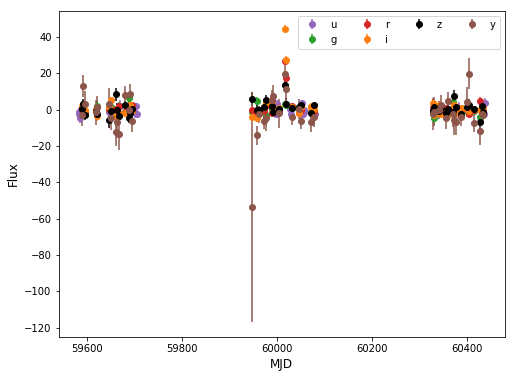

64 1573501


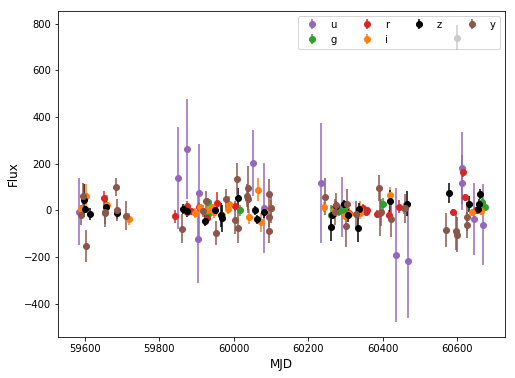

64 3572446


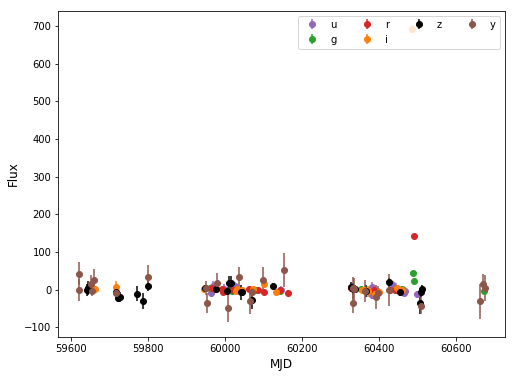

64 4311960


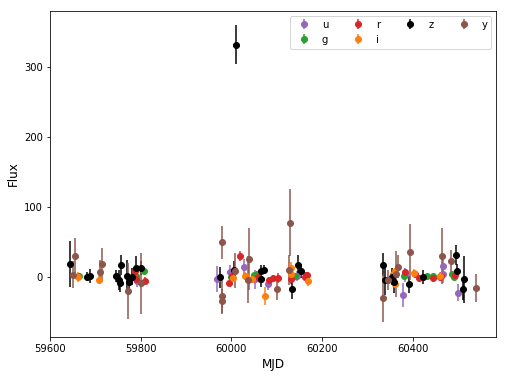

64 4539153


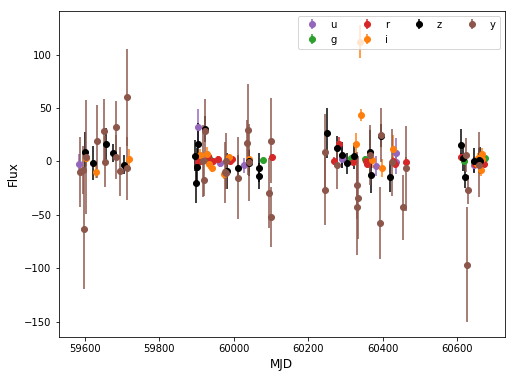

64 5102349


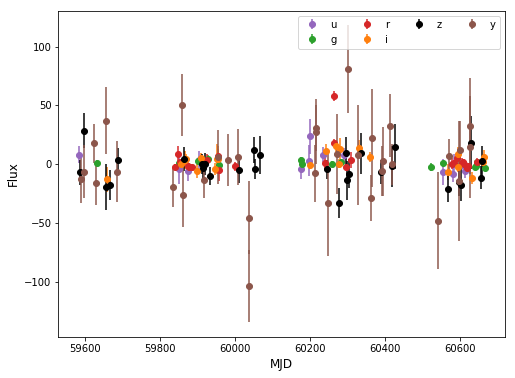

64 6460481


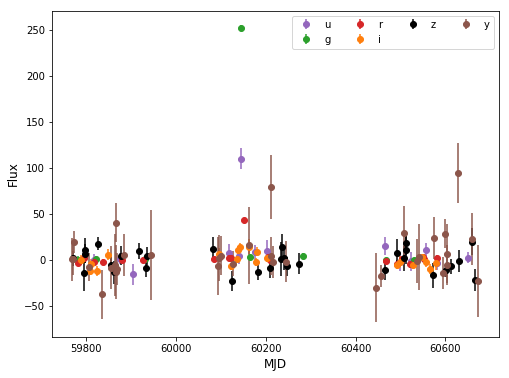

64 11574036


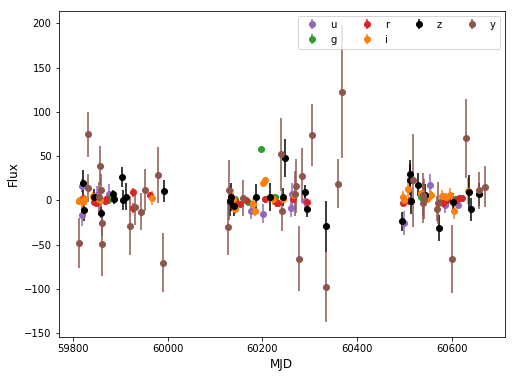

64 11742403


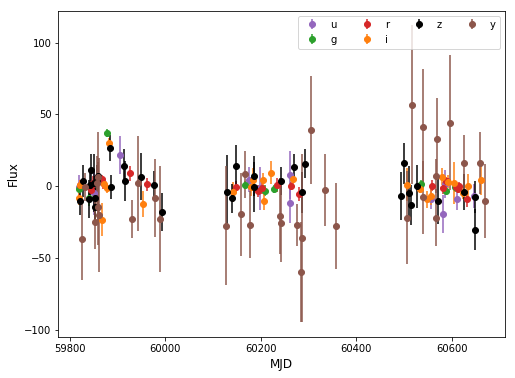

65 1227


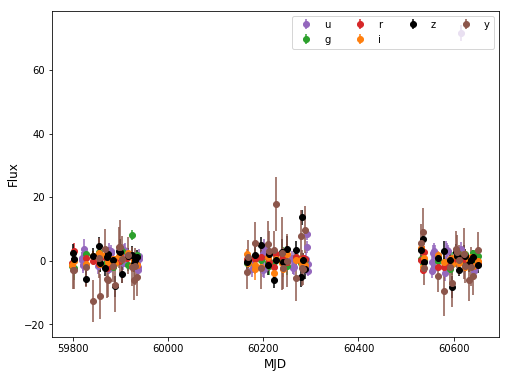

65 1926


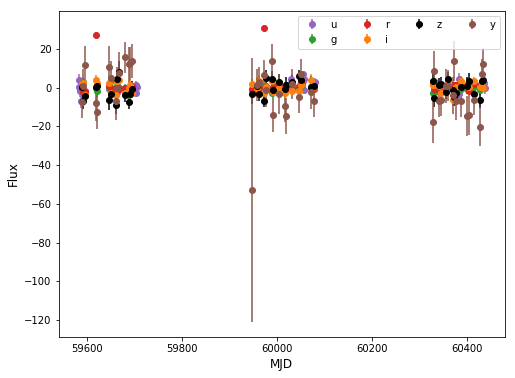

65 2624


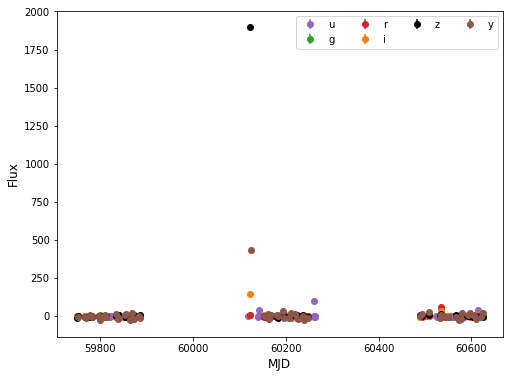

65 6266


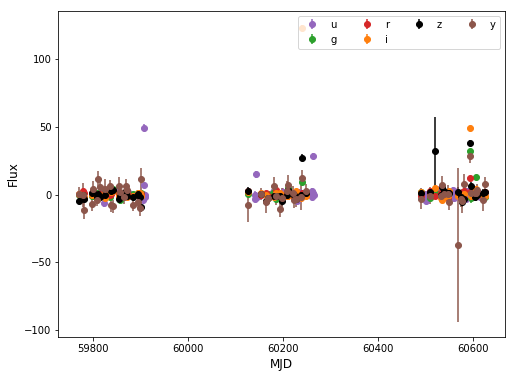

65 8688


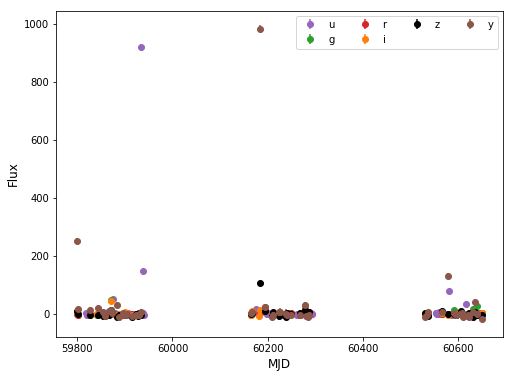

65 9006


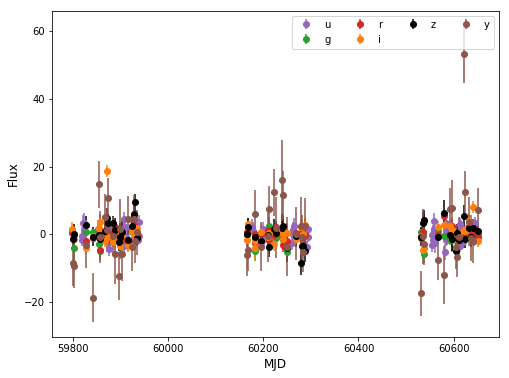

65 9172


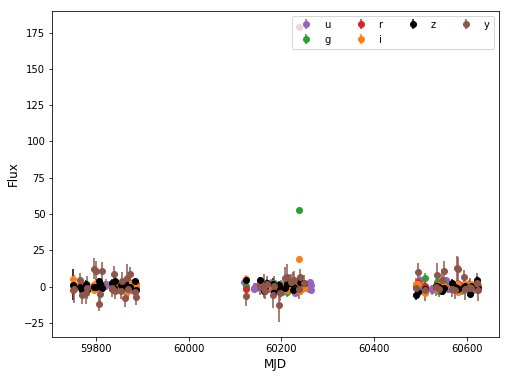

65 9543


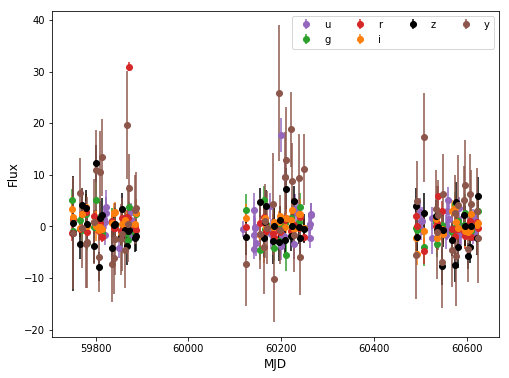

65 9985


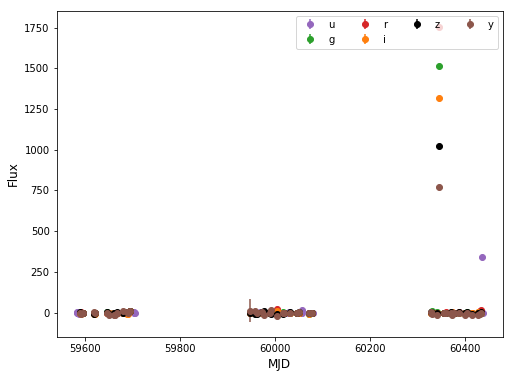

65 10349


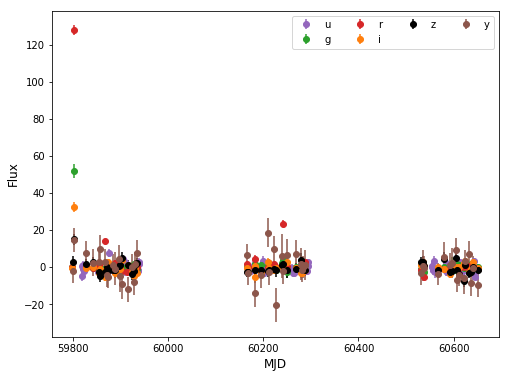

67 2922


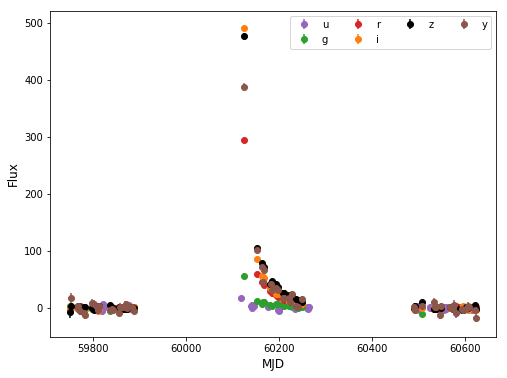

67 3041


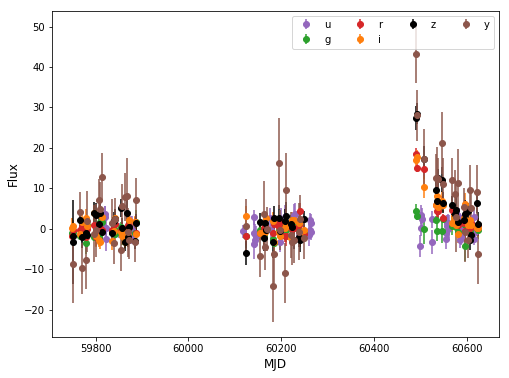

67 19154


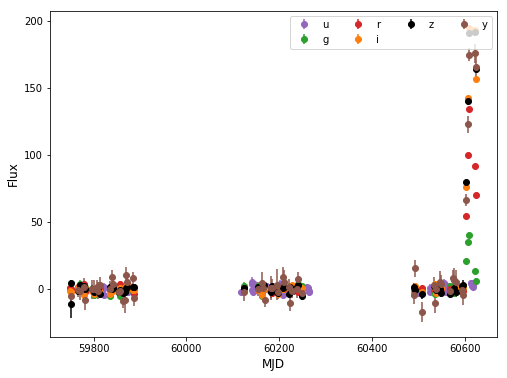

67 28636


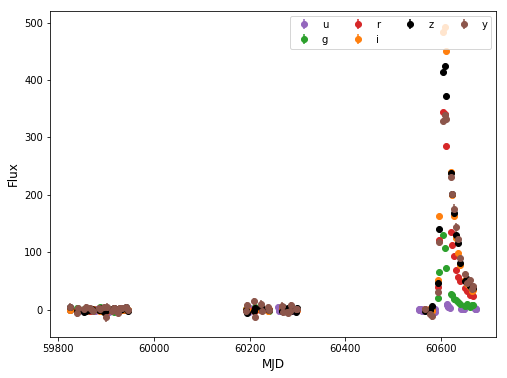

67 34437


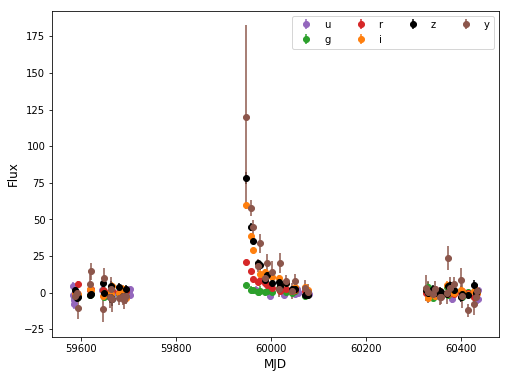

67 37872


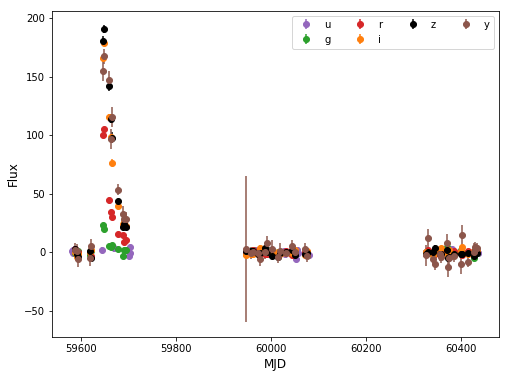

67 42333


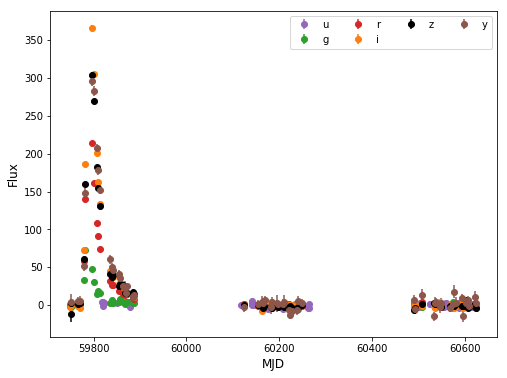

67 45349


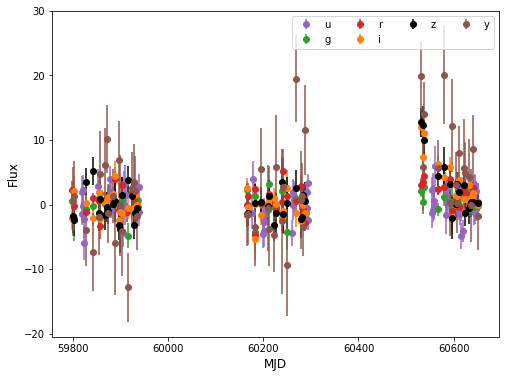

67 48725


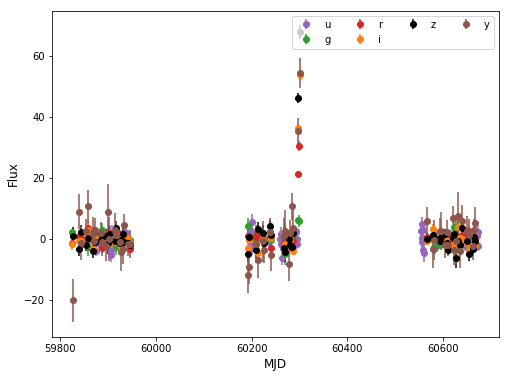

67 50277


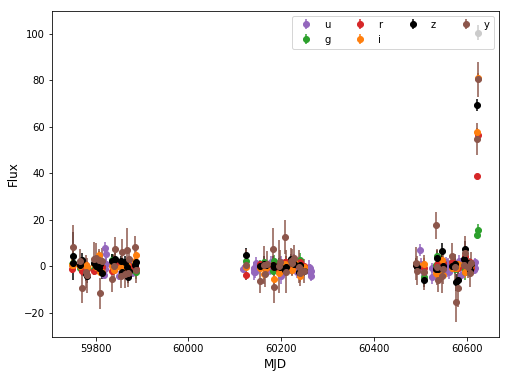

88 713


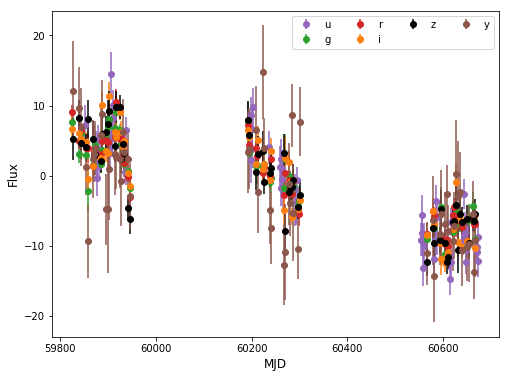

88 3489


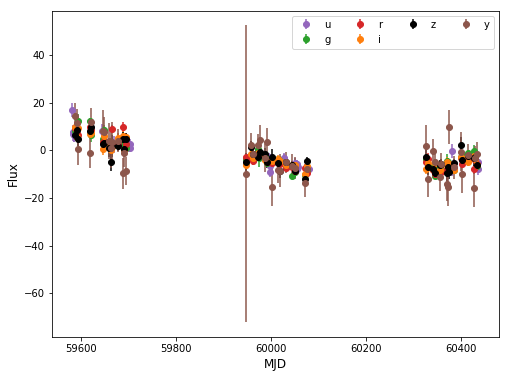

88 4088


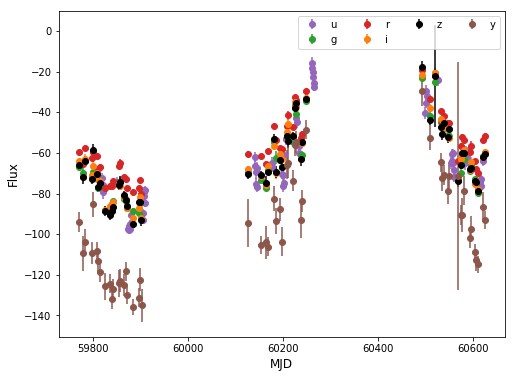

88 7315


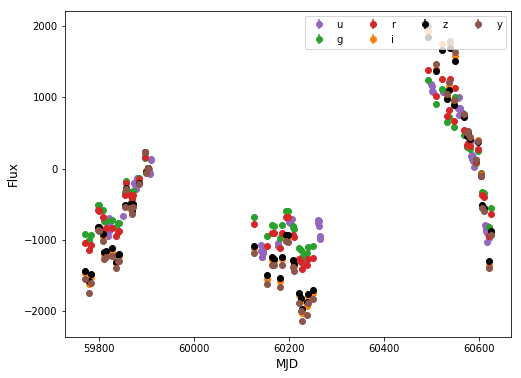

88 7409


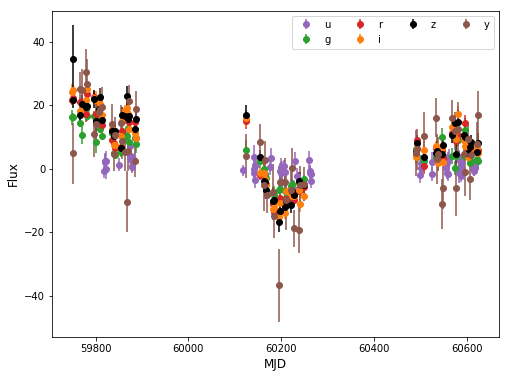

88 9184


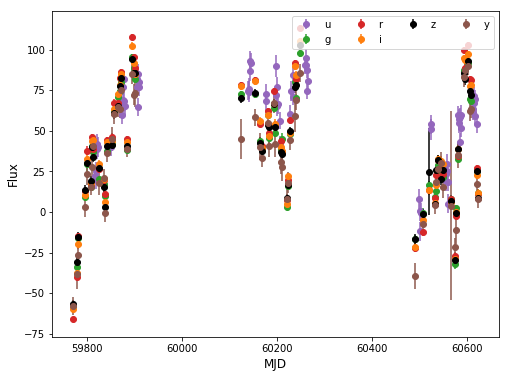

88 10586


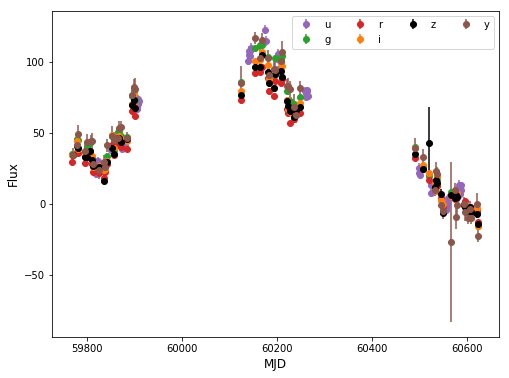

88 14539


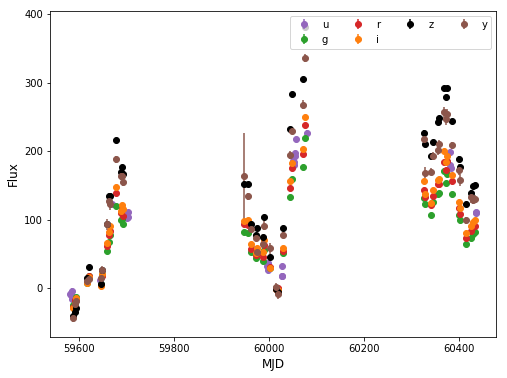

88 18507


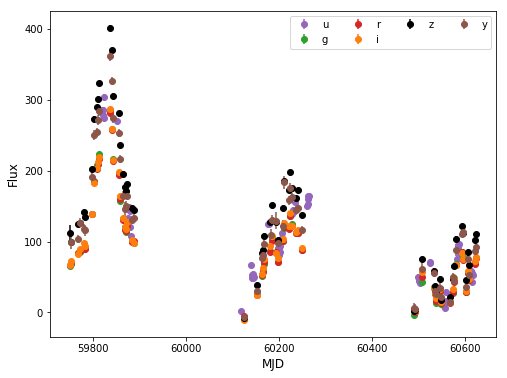

88 23299


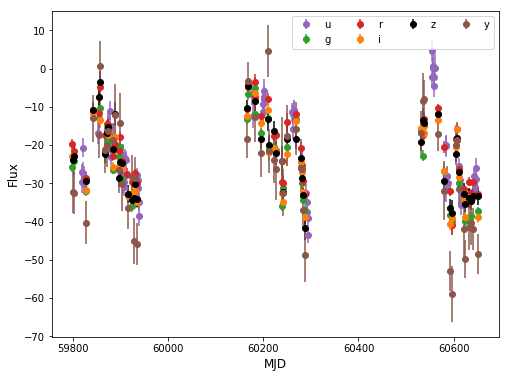

90 745


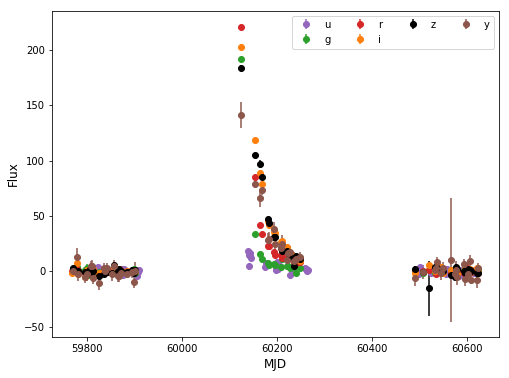

90 1124


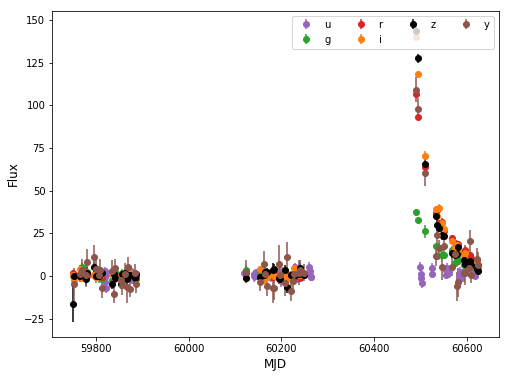

90 1598


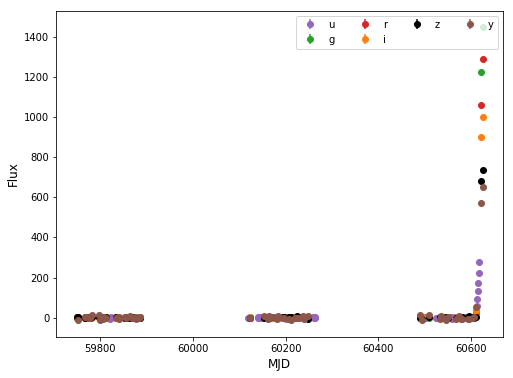

90 1920


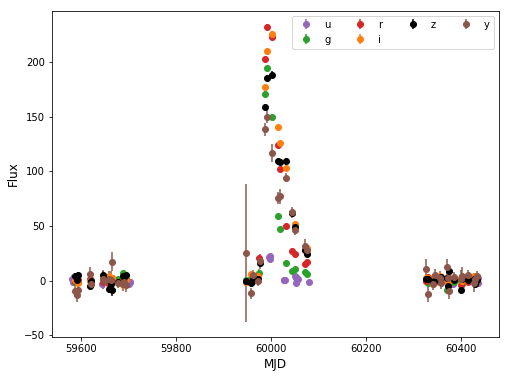

90 2072


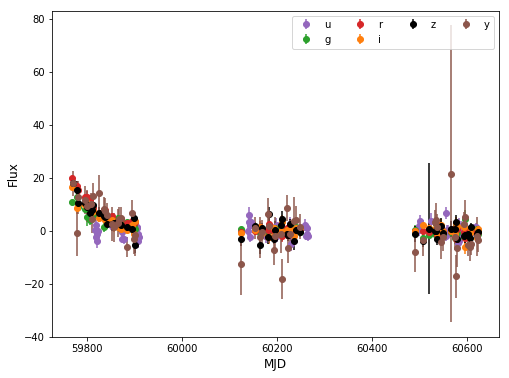

90 2330


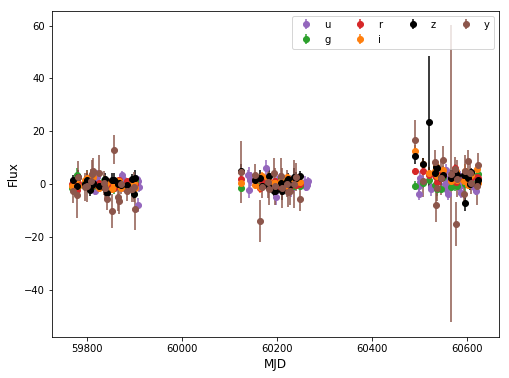

90 4389


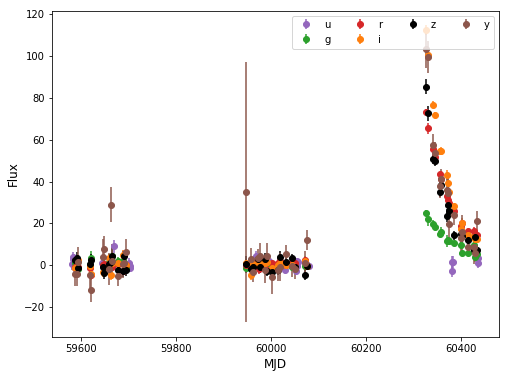

90 4595


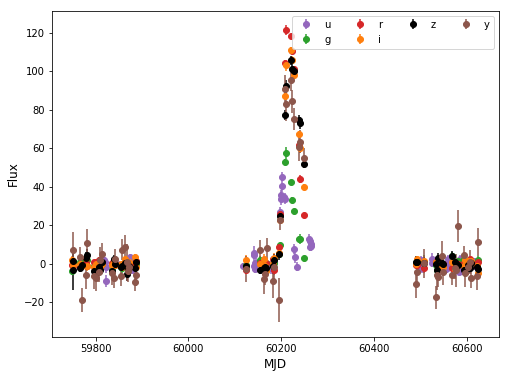

90 4819


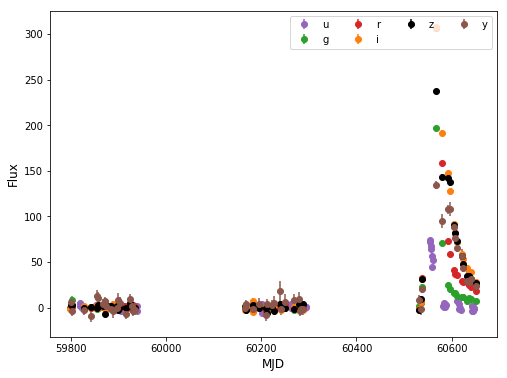

90 6180


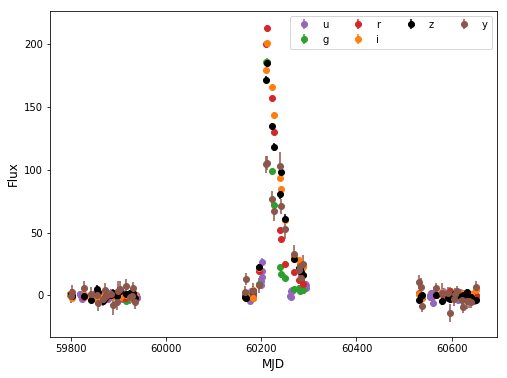

92 615


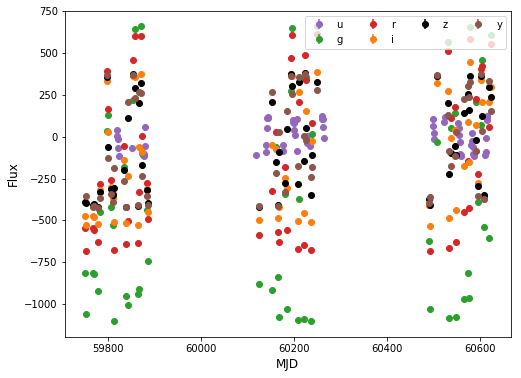

92 12695


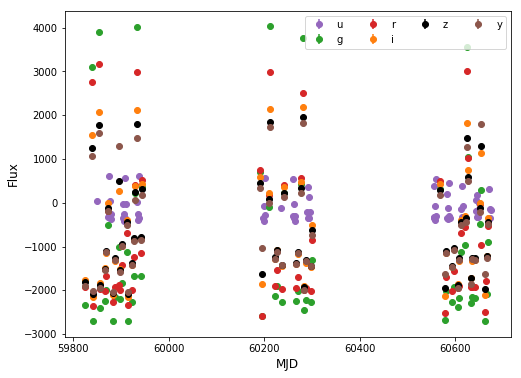

92 26161


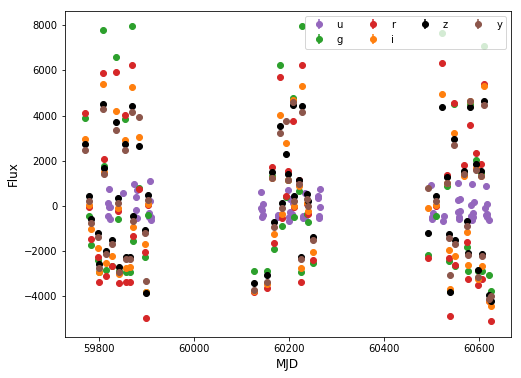

92 26783


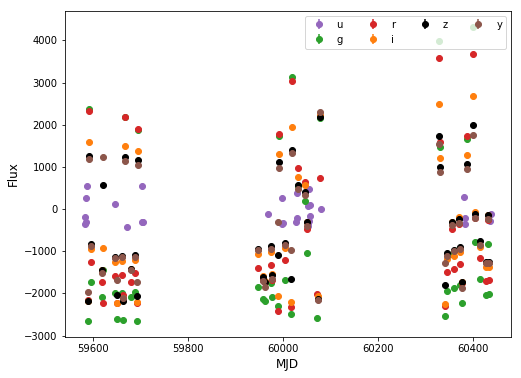

92 28391


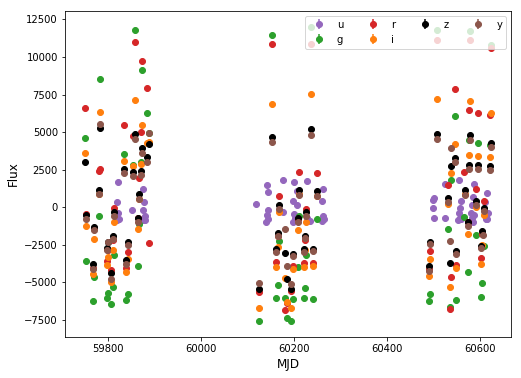

92 31310


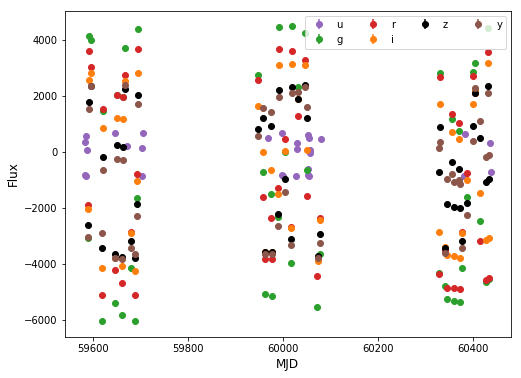

92 43509


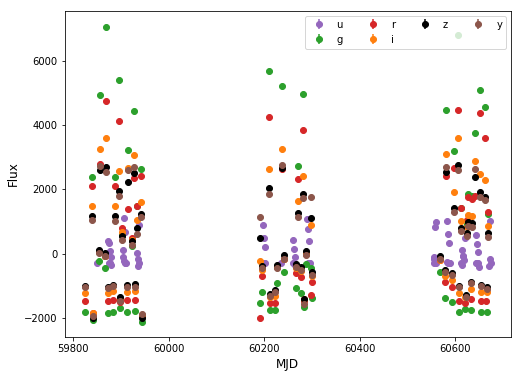

92 49389


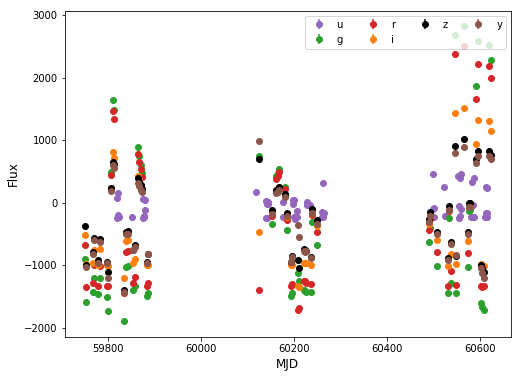

92 51987


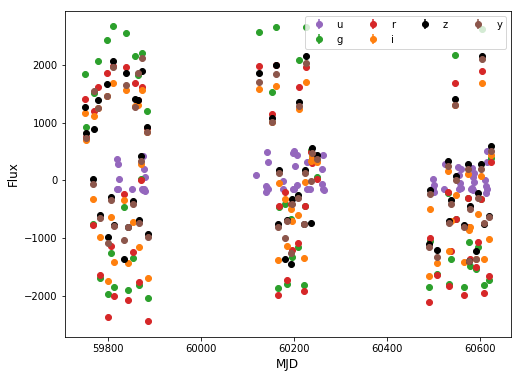

92 61407


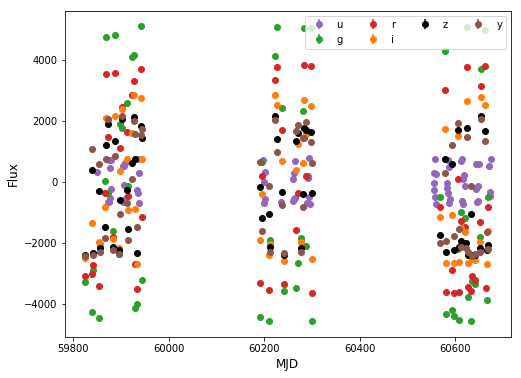

95 3423


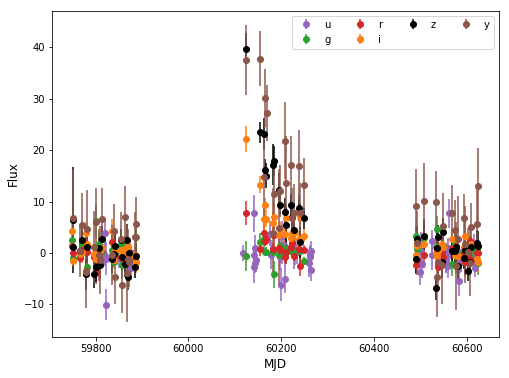

95 10321


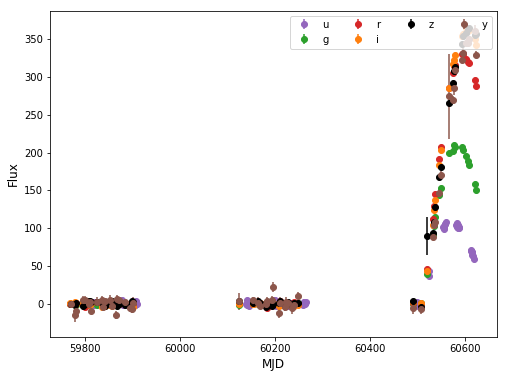

95 14553


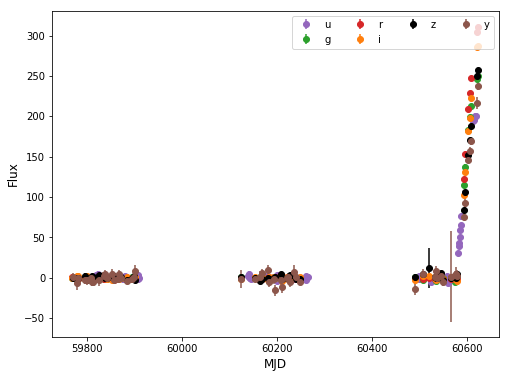

95 23539


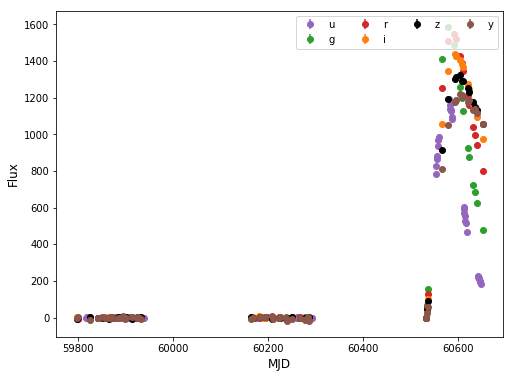

95 31569


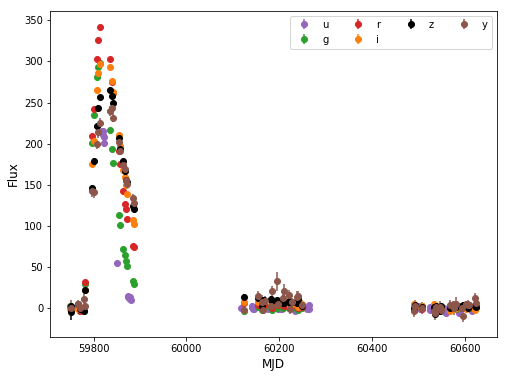

95 35315


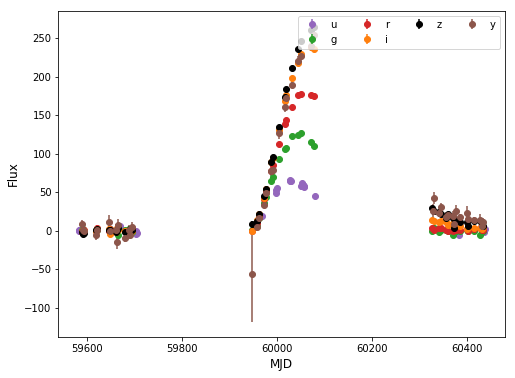

95 42469


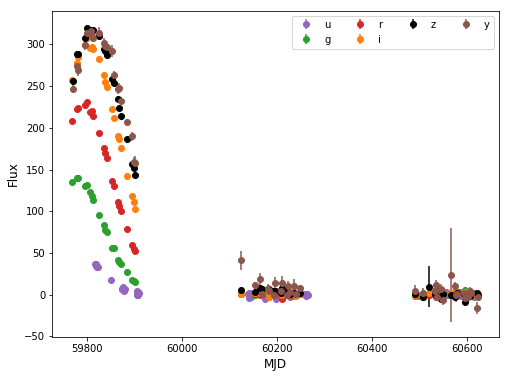

95 73610


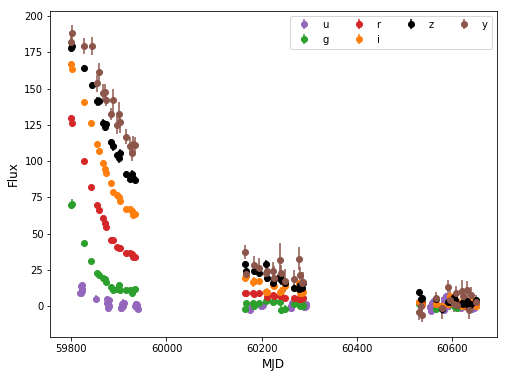

95 76304


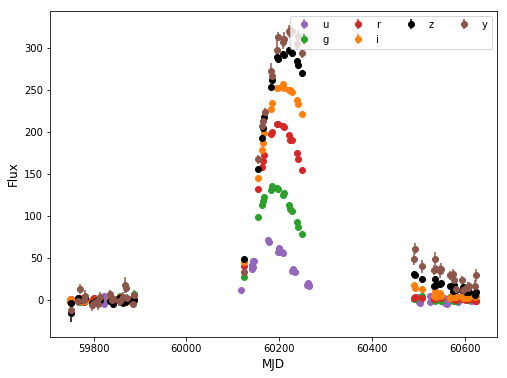

95 77391


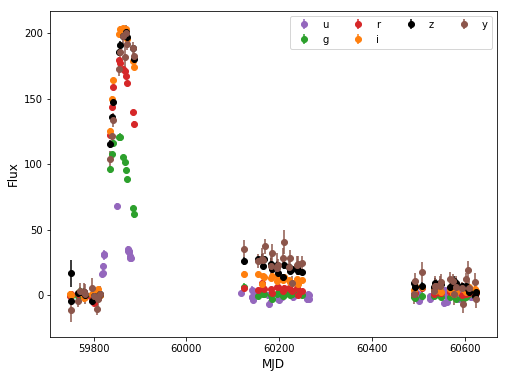

In [11]:
for target in np.sort(train_meta.target.unique()):
    objects = train_meta.query('target==@target').object_id.head(10).values
    for obj in objects:
        print(target, obj)
        extract = train_ts.query('object_id==@obj')
        lc = LightCurve(extract)
        lc.plot_multicolor_lc()
        plt.show()

In [17]:
from gatspy.periodic import LombScargleMultiband
def get_spectrum(lc):
    model = LombScargleMultiband(fit_period=True)
    t_min = max(np.median(np.diff(sorted(lc.DFlc['mjd']))), 0.1)
    t_max = min(10., (lc.DFlc['mjd'].max() - lc.DFlc['mjd'].min())/2.)
    model.optimizer.set(period_range=(t_min, t_max), first_pass_coverage=5)
    model.fit(lc.DFlc['mjd'], lc.DFlc['flux'], dy=lc.DFlc['flux_err'], filts=lc.DFlc['passband'])
    period = model.best_period
    phase = (lc.DFlc['mjd'] /period) % 1
    
    return lc, phase

6 18556
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


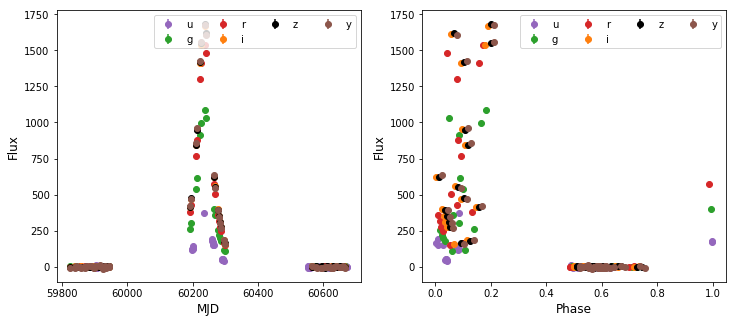

6 77157
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


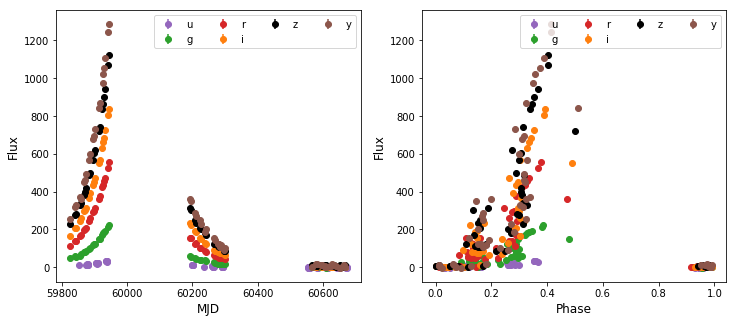

6 83348
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


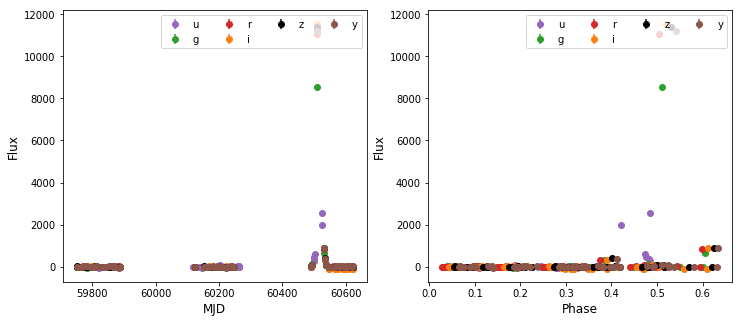

6 198103
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


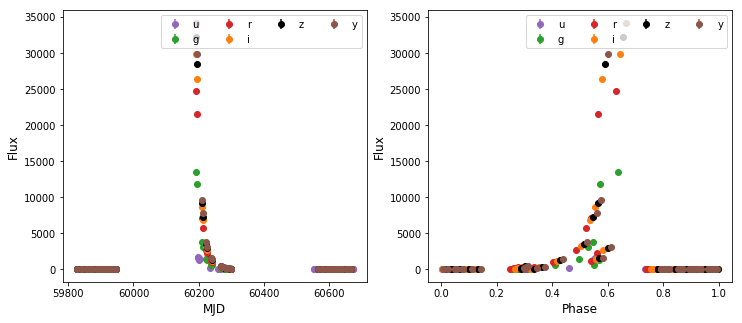

15 4173
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


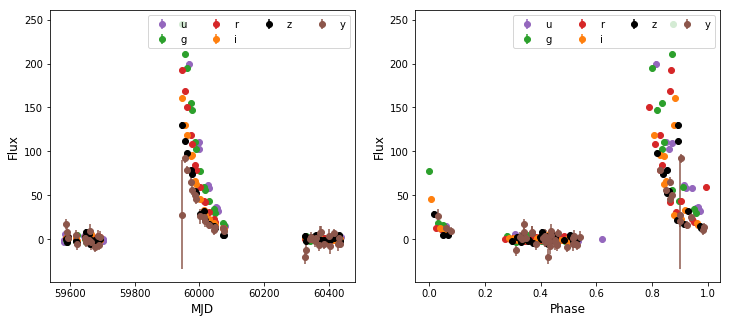

15 23116
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


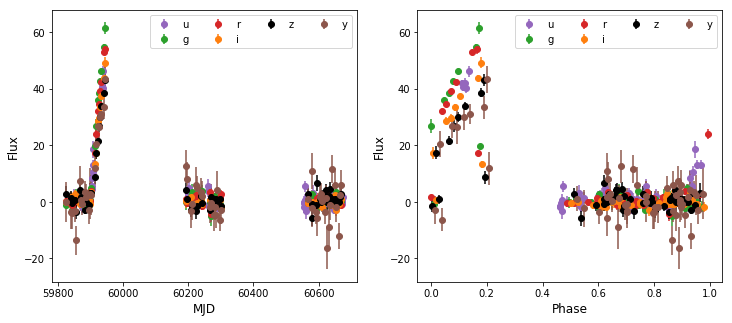

15 97406
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


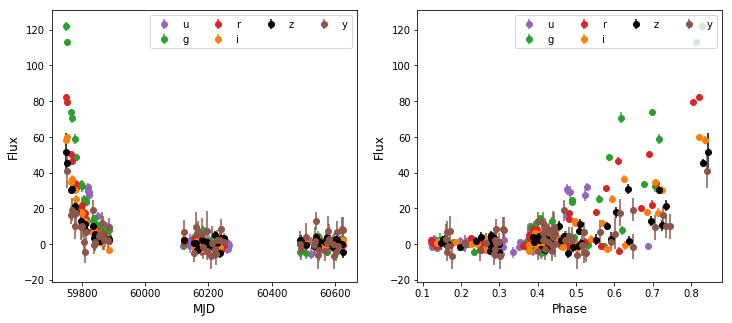

15 113669
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


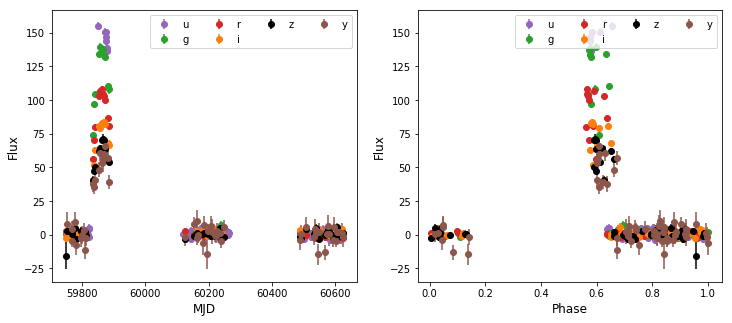

16 2677
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


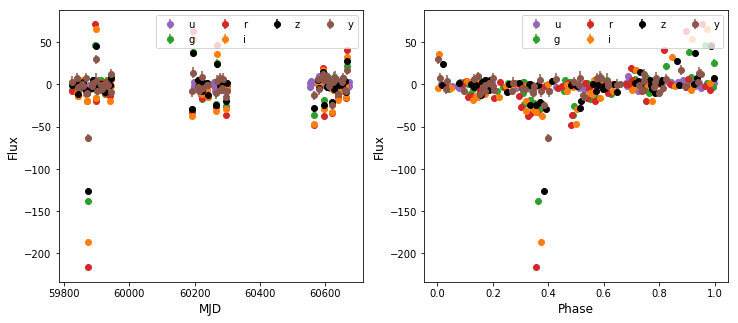

16 4171
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


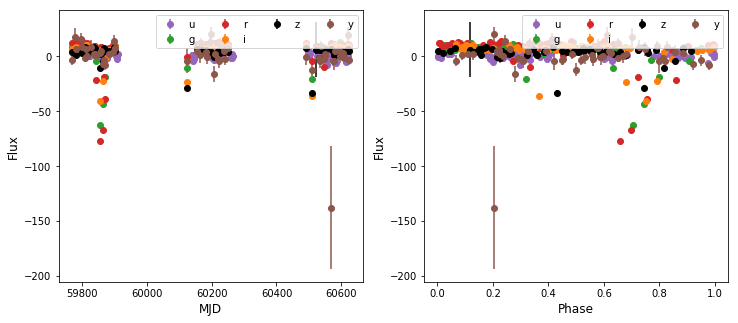

16 7566
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


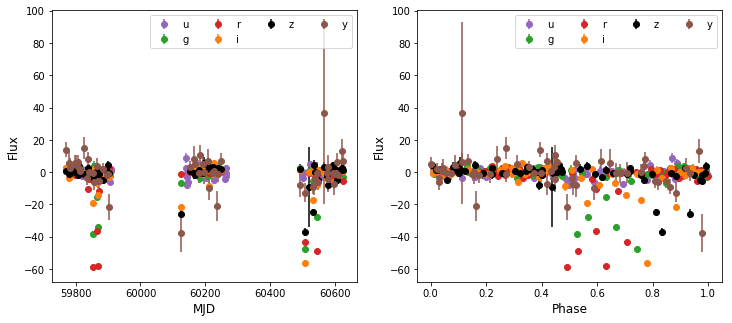

16 7756
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


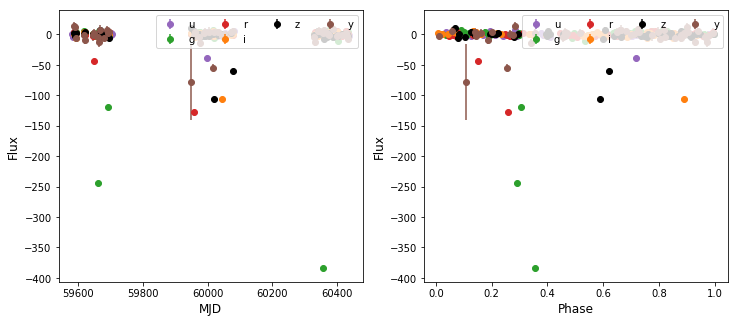

42 730
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


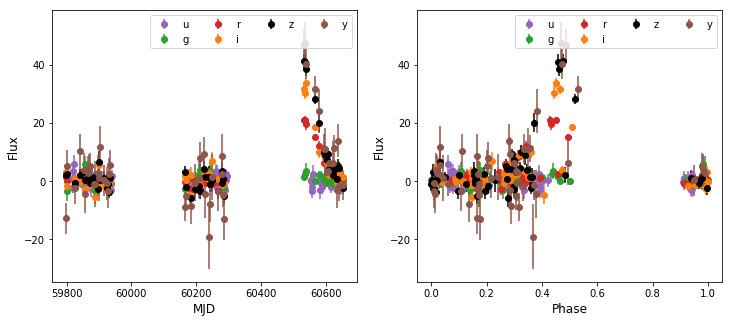

42 1632
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


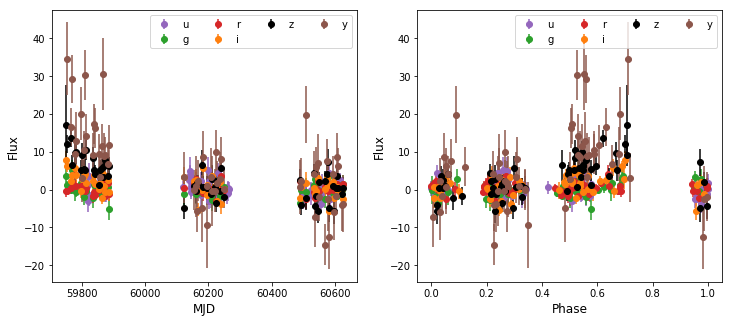

42 2103
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


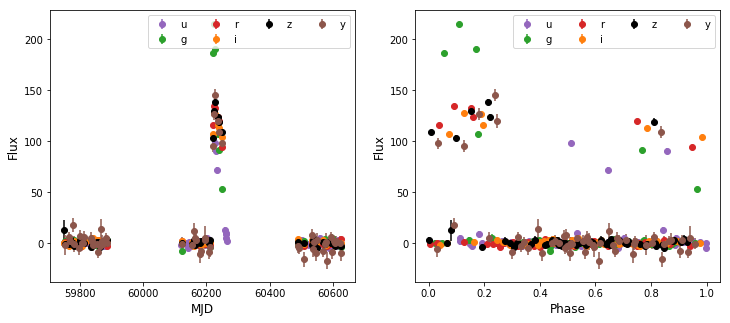

42 2300
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


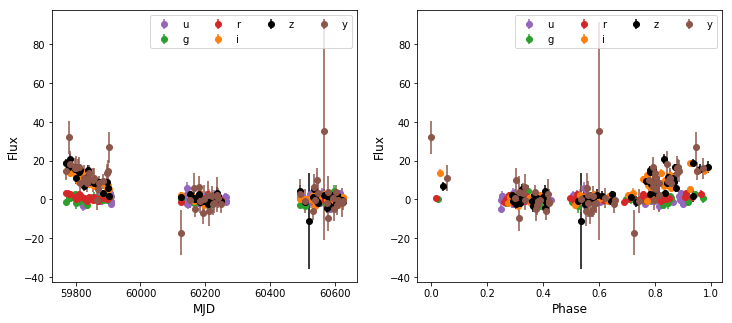

52 10757
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


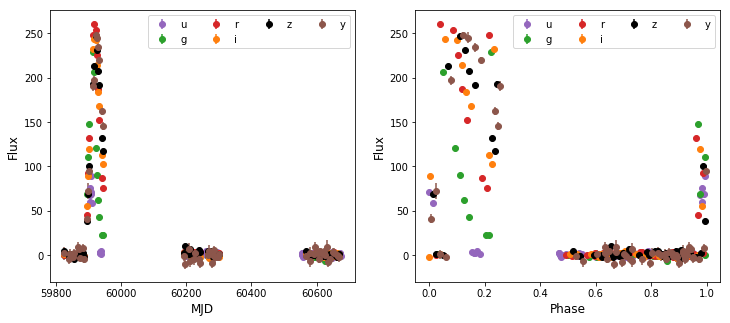

52 11773
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


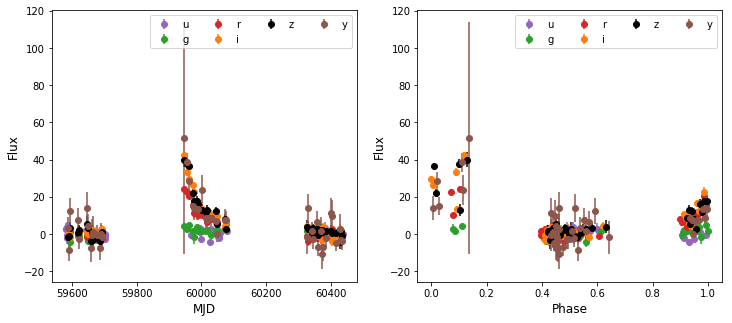

52 13138
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


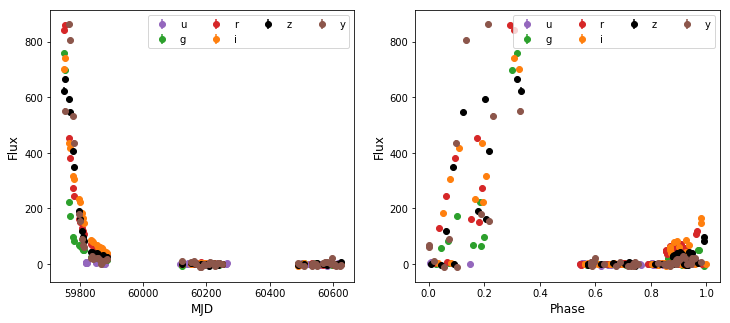

52 14279
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


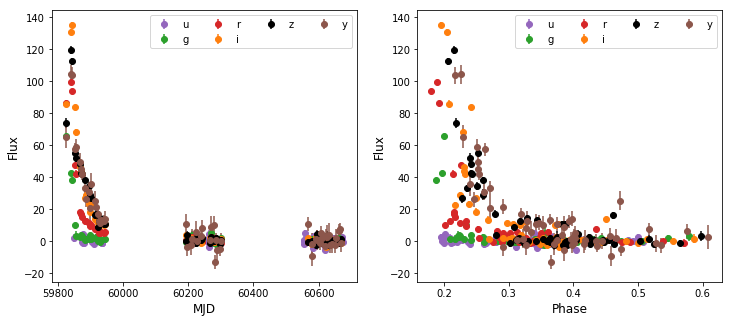

53 133773
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


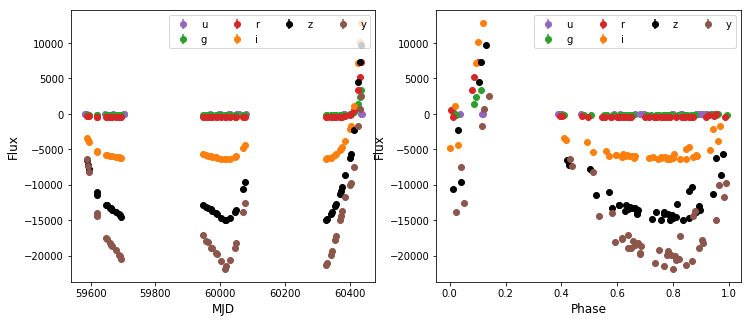

53 268977
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


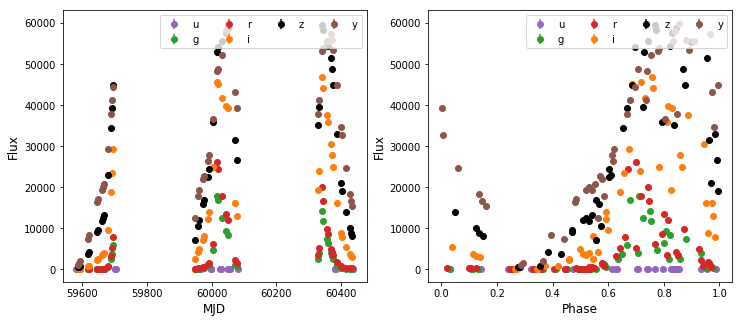

53 278480
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


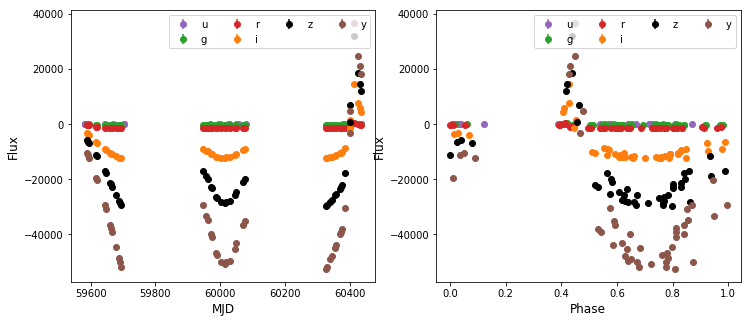

53 288194
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


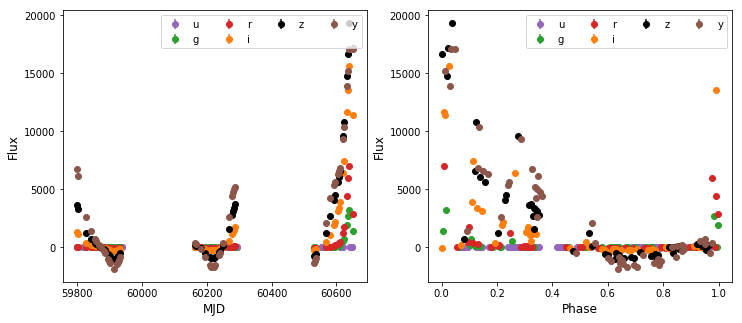

62 3910
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


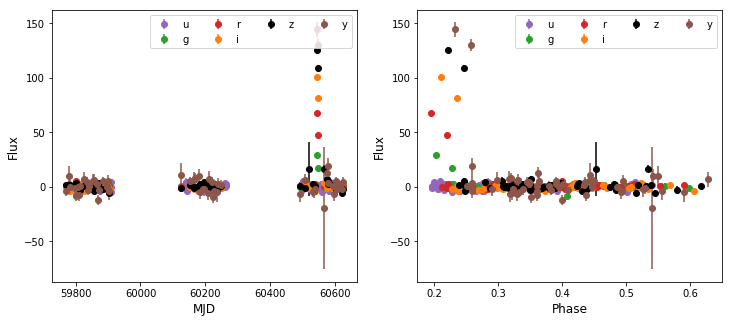

62 7703
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


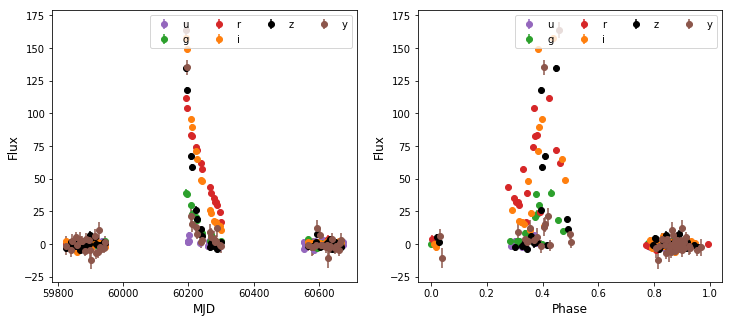

62 11770
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


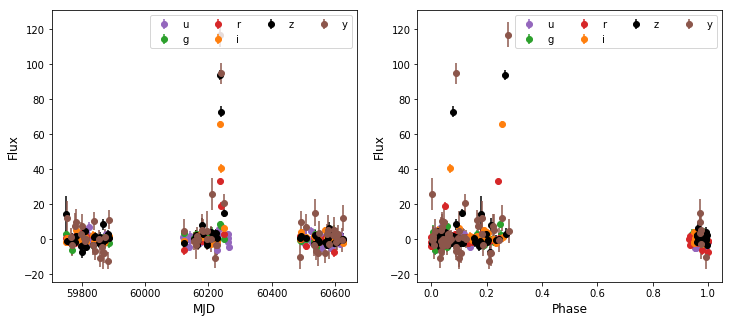

62 17370
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


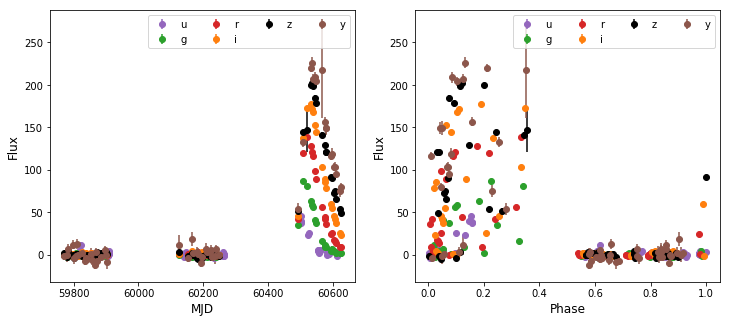

64 62187
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


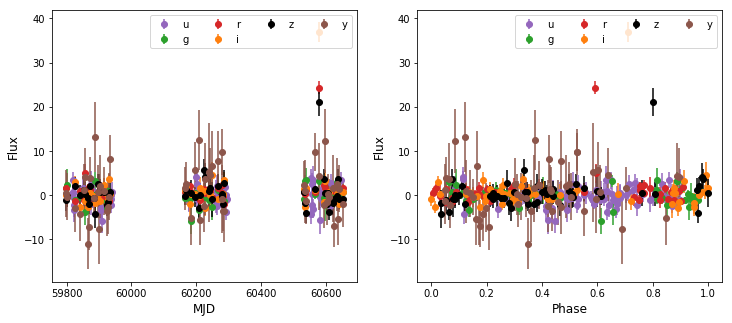

64 139362
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


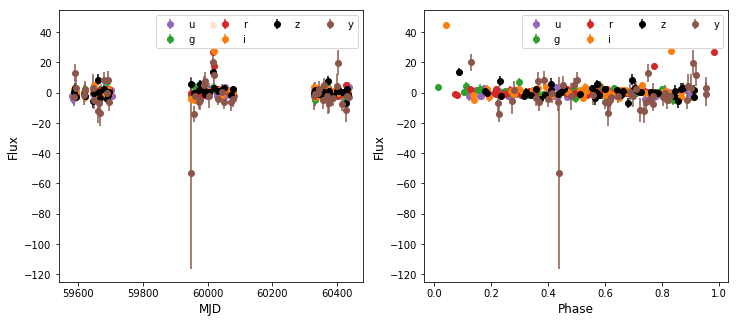

65 1227
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


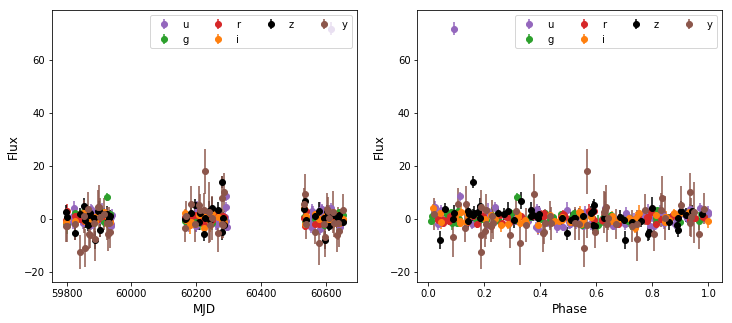

65 1926
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


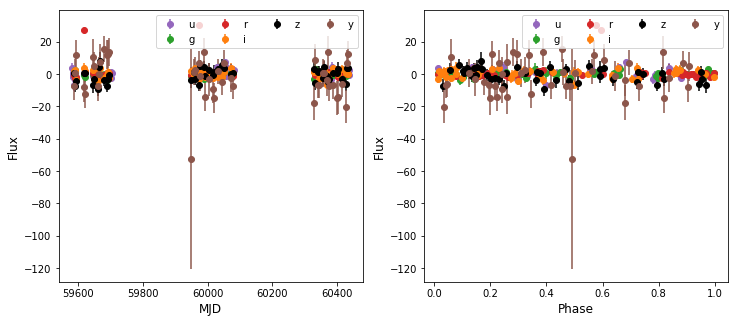

65 2624
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


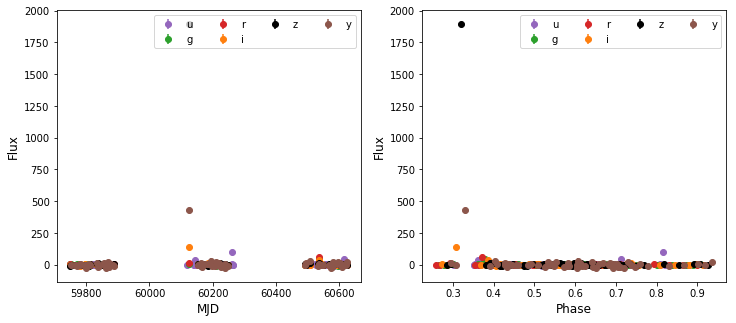

65 6266
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


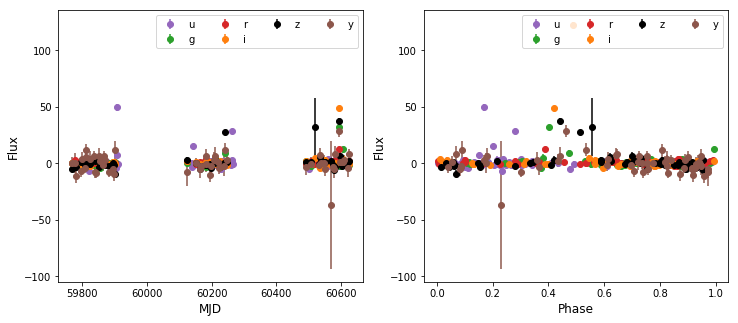

67 2922
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


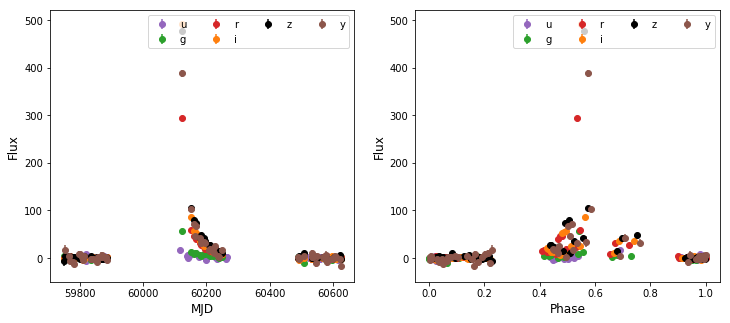

67 3041
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


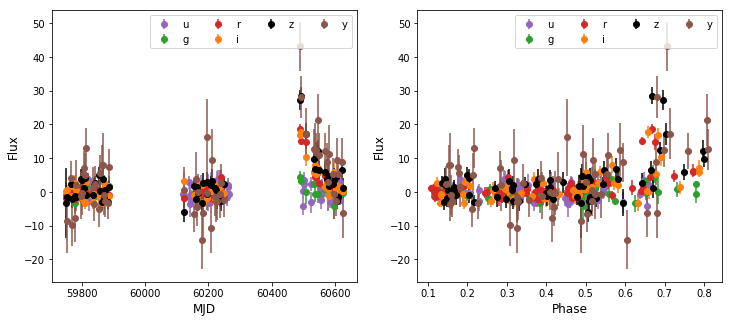

67 19154
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


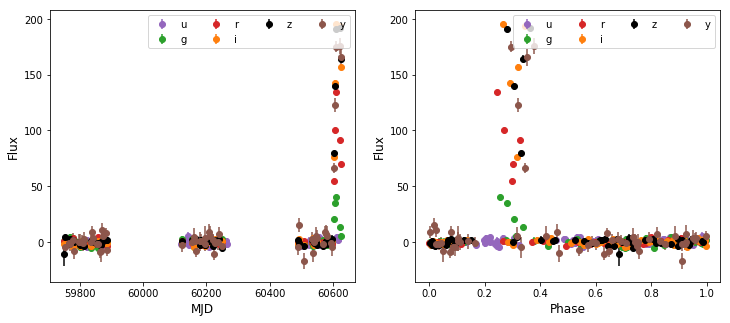

67 28636
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


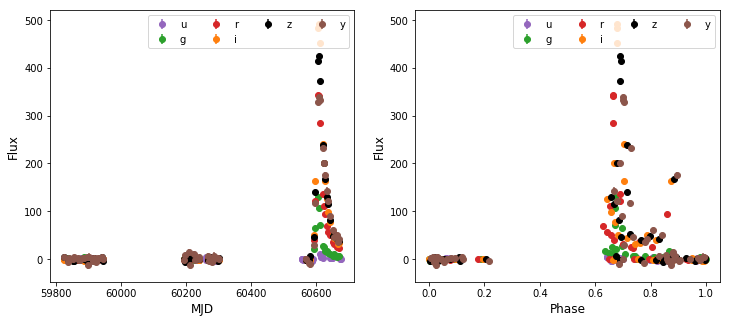

88 713
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


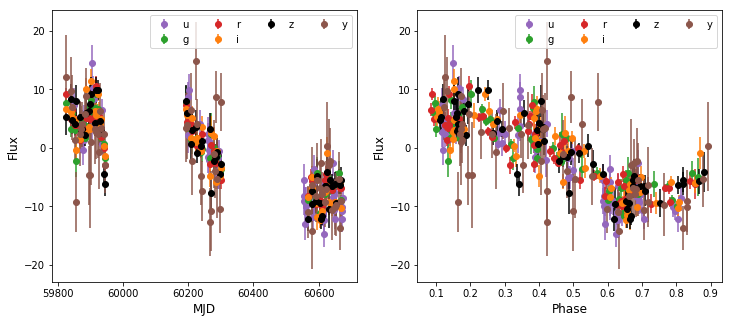

88 3489
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


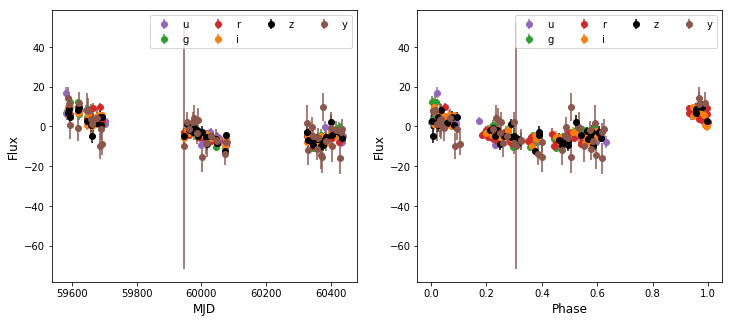

88 4088
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


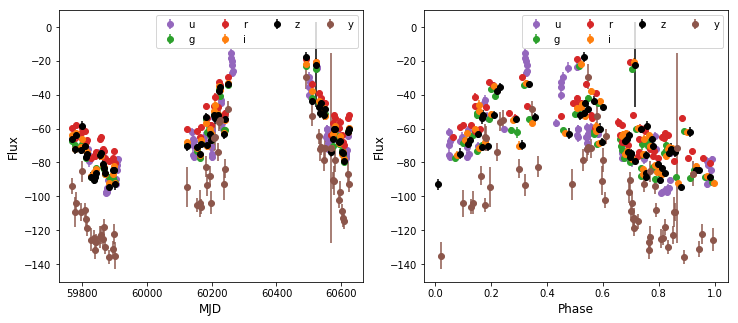

88 7315
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


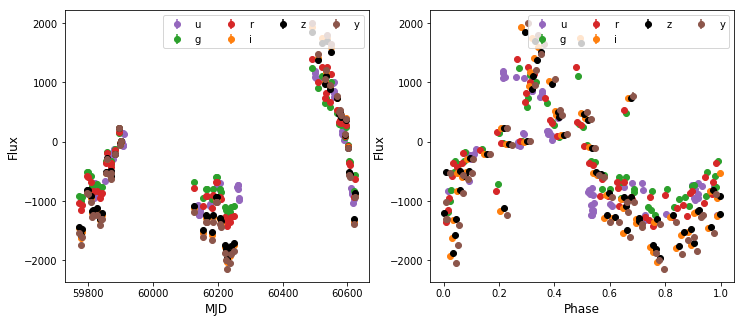

90 745
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


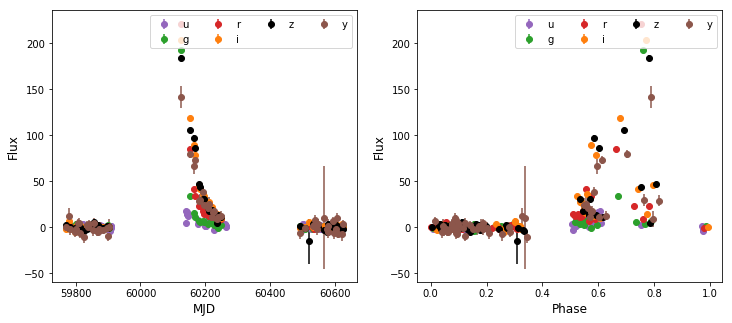

90 1124
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


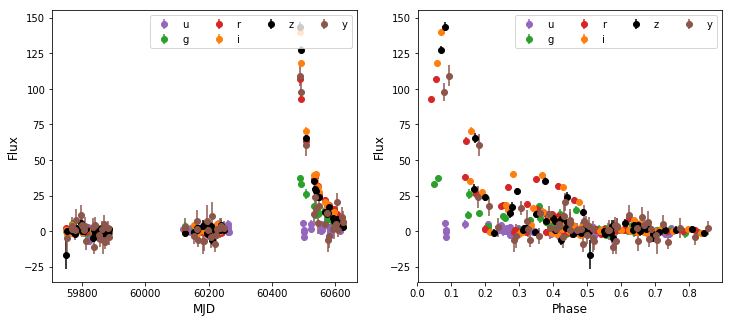

90 1598
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


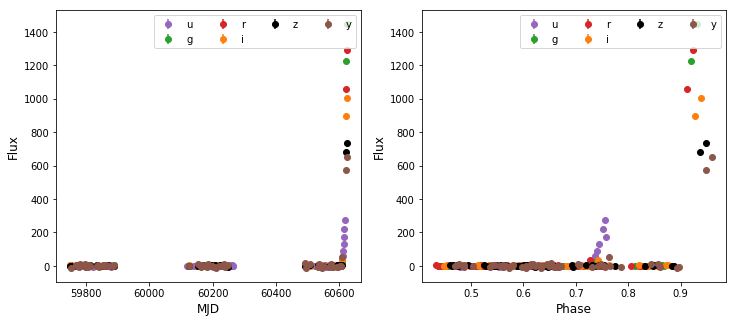

90 1920
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


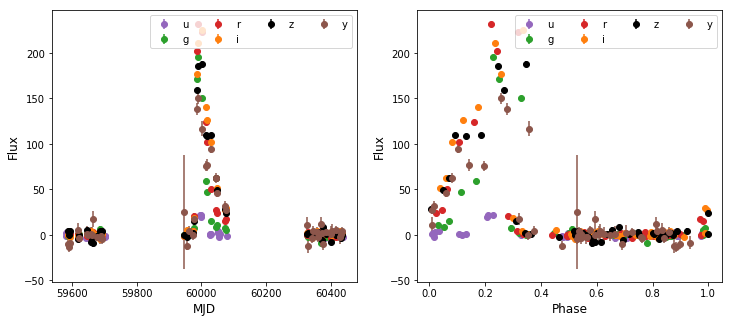

92 615
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


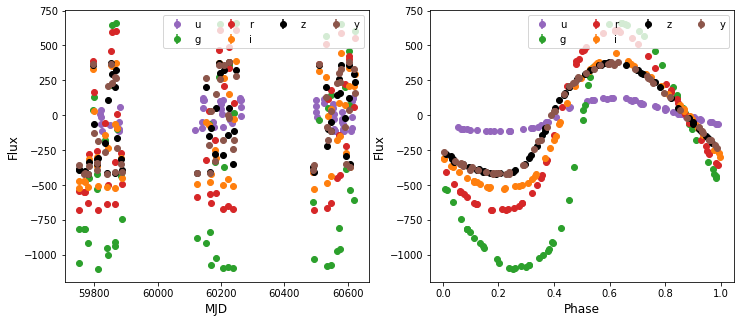

92 12695
Finding optimal frequency:
 - Estimated peak width = 0.0074
 - Using 5 steps per peak; omega_step = 0.00148
 - User-specified period range:  0.1 to 10
 - Computing periods at 42018 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


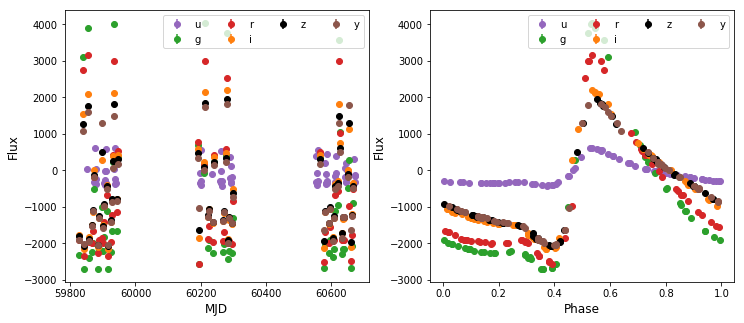

92 26161
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


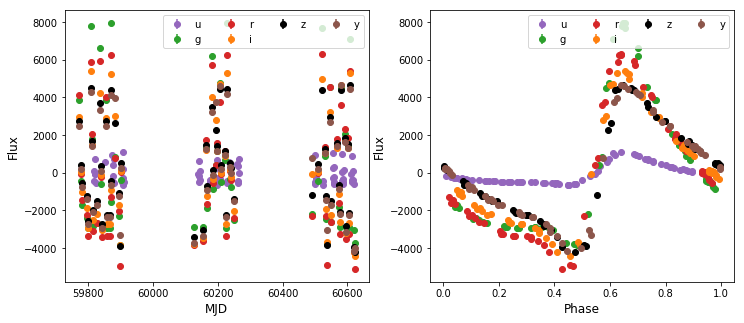

92 26783
Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42307 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


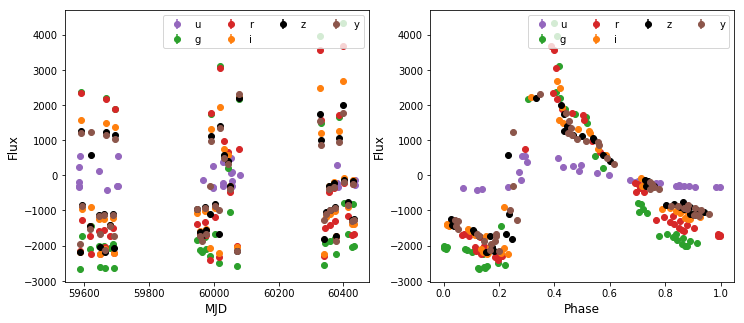

95 3423
Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 10
 - Computing periods at 43254 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


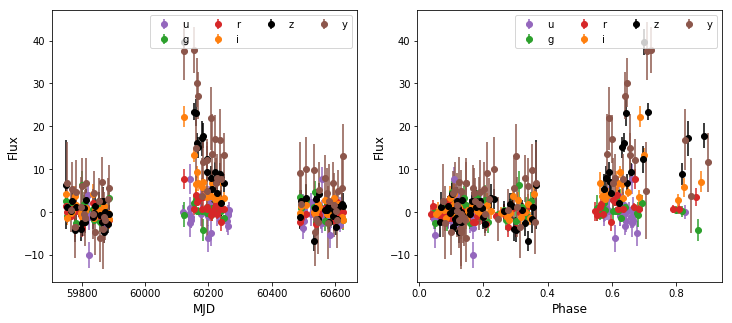

95 10321
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


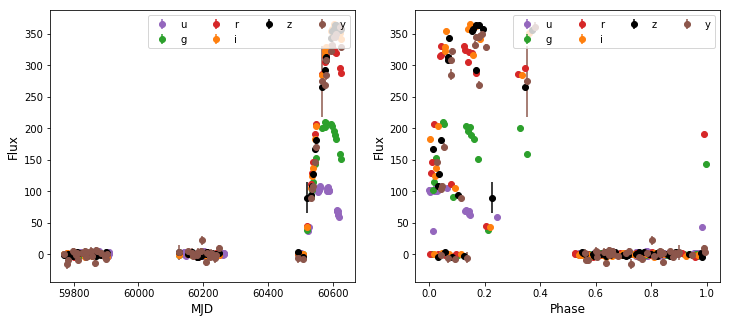

95 14553
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42260 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


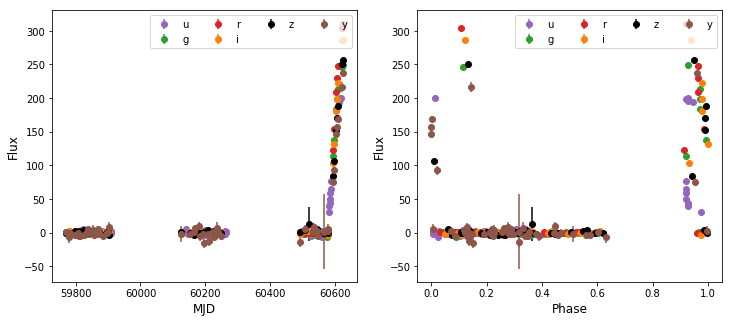

95 23539
Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 10
 - Computing periods at 42267 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


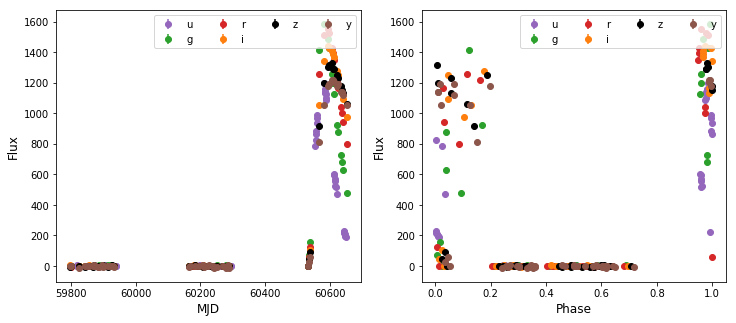

In [35]:
# plotする対象を抽出
for target in np.sort(train_meta.target.unique()):
    objects = train_meta.query('target==@target and ddf==1').object_id.head(4).values
    for obj in objects:
        print(target, obj)
        extract = train_ts.query('object_id==@obj')
        lc = LightCurve(extract)
        
        fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
        lc.plot_multicolor_lc(ax=axes[0])
        
        lc, phase = get_spectrum(lc)
        lc.plot_multicolor_lc(phase=phase, ax=axes[1])
        plt.show()

6 18556


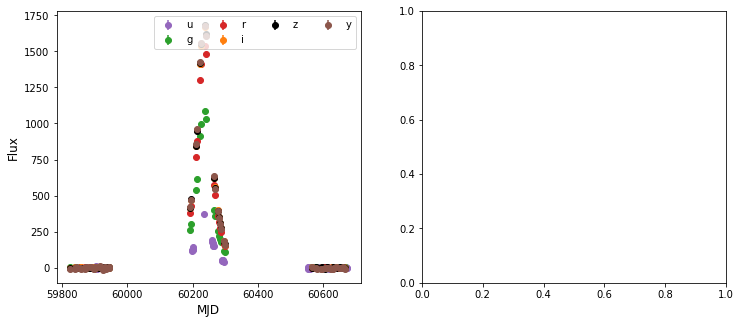

6 77157


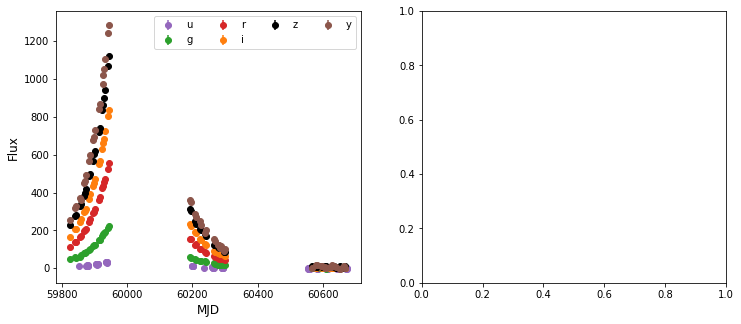

6 83348


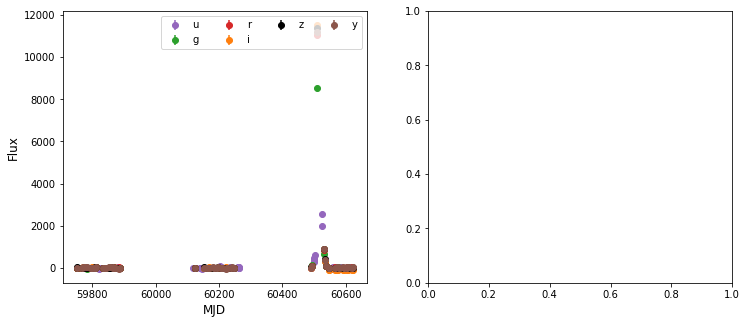

6 198103


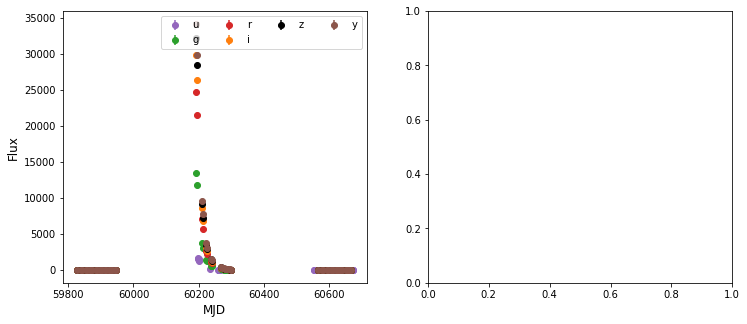

15 4173


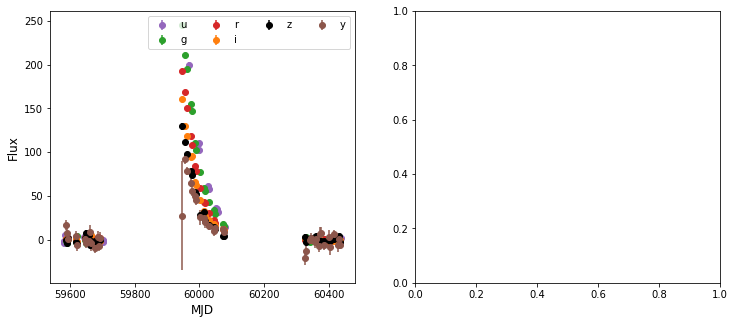

15 23116


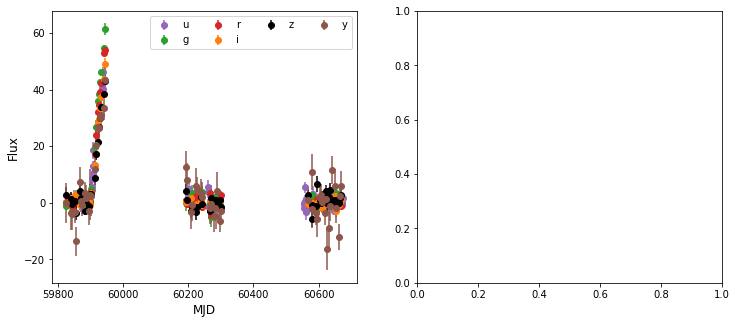

15 97406


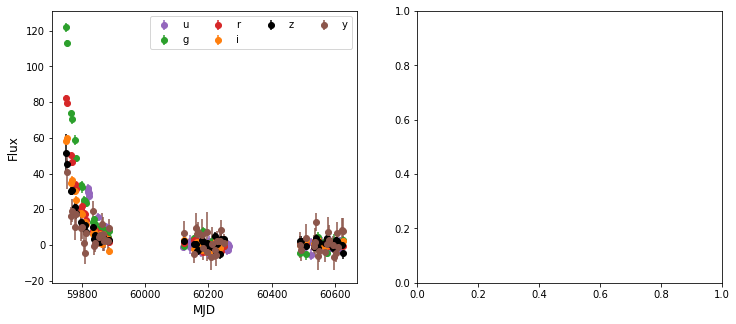

15 113669


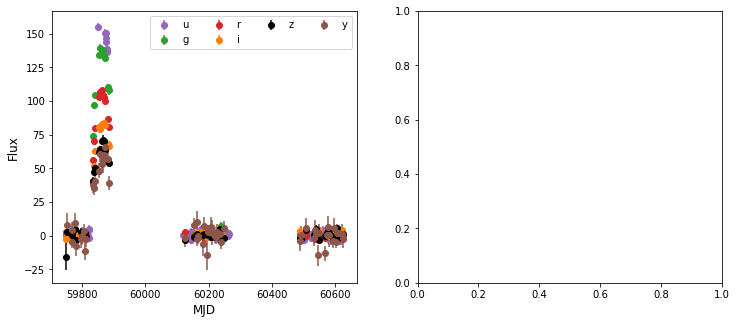

16 2677


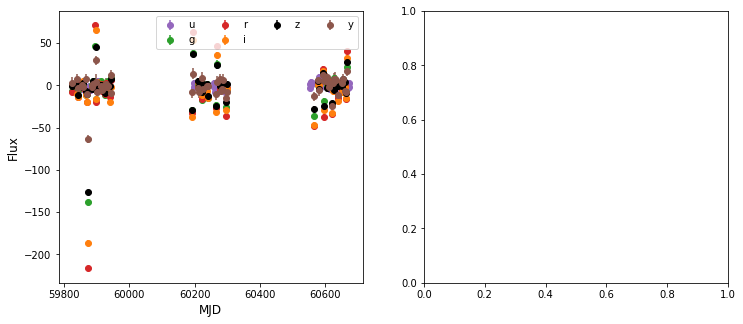

16 4171


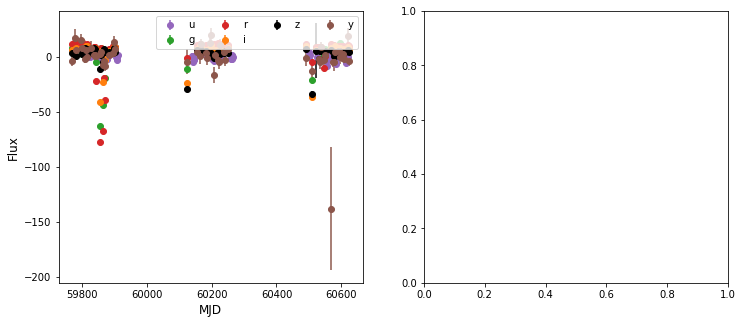

16 7566


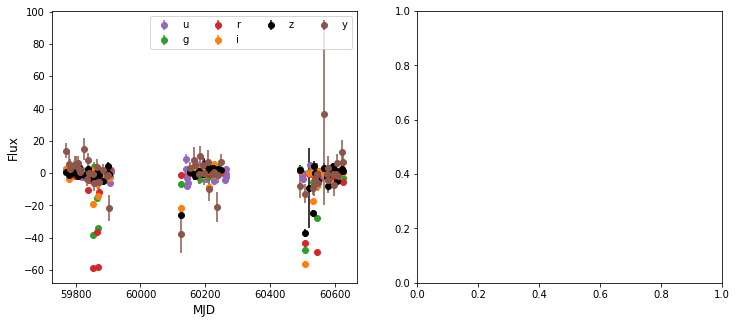

16 7756


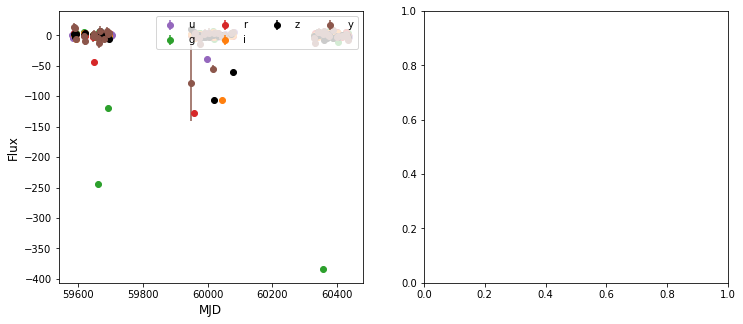

42 730


KeyboardInterrupt: 

In [36]:
for target in np.sort(train_meta.target.unique()):
    objects = train_meta.query('target==@target and ddf==1').object_id.head(4).values
    for obj in objects:
        print(target, obj)
        extract = train_ts.query('object_id==@obj')
        lc = LightCurve(extract)
        
        fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
        lc.plot_multicolor_lc(ax=axes[0])
        plt.show()

### passbandについて

In [17]:
train_ts.groupby('passband').size()

passband
0    197493
1    176499
2    238049
3    233520
4    277119
5    299025
dtype: int64